<a href="https://colab.research.google.com/github/LoQiseaking69/SephsBIOME/blob/master/Docs/Model/Tests/Utils/SynthDGenV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Synthetic Dataset Generation

This notebook demonstrates the generation of a sophisticated synthetic dataset, incorporating advanced techniques for NLP data generation and kinematic feature extraction.

In [17]:
%%capture
!pip install markovify

In [18]:
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import nltk
from nltk.corpus import brown
import markovify
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.under_sampling import RandomUnderSampler

nltk.download('brown')


[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

## NLP Data Generation Using Brown Corpus

In [19]:
# Generate text data using Markov chains built from the Brown corpus
text = ' '.join(brown.words())
text_model = markovify.Text(text)

def generate_text_data(num_samples):
    return [text_model.make_short_sentence(100) for _ in range(num_samples)]


## Synthetic Dataset Generation Function

In [20]:
def generate_synthetic_dataset(num_samples=1000, num_sensors=128, num_actions=10, noise_level=0.05):
    timestamps = [datetime.now() + timedelta(seconds=i) for i in range(num_samples)]
    text_data = generate_text_data(num_samples)
    sensor_data = {}
    for i in range(num_sensors):
        period = np.random.randint(10, 100)
        sensor_data[f'sensor_{i}'] = np.sin(np.linspace(0, 2 * np.pi * period, num_samples)) + np.random.normal(0, noise_level, num_samples)
    action_data = np.random.randint(0, num_actions, num_samples)
    reward_data = np.random.uniform(-1, 1, num_samples)
    return pd.DataFrame({
        'timestamp': timestamps,
        'text_data': text_data,
        **sensor_data,
        'action': action_data,
        'reward': reward_data
    })


## Dataset Reorganization for Reinforcement Learning

In [21]:

def reorganize_for_rl(df, num_sensors=128):
    sensor_columns = [f'sensor_{i}' for i in range(num_sensors)]
    action_counts = df['action'].value_counts()
    min_count = action_counts.min()
    balanced_df = pd.concat([df[df['action'] == action].sample(min_count) for action in action_counts.index])
    return df


## Feature Engineering

In [23]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def feature_engineering(df):
    scaler = StandardScaler()
    for col in df.columns:
        if col.startswith('sensor_'):
            # Standardize the sensor data
            df[col] = scaler.fit_transform(df[[col]])

            # Add some random noise to introduce variability
            noise_strength = 0.05  # Adjust this value based on the desired level of noise
            noise = np.random.normal(0, noise_strength, df[col].shape)
            df[col] += noise

    return df

def wrangle_data(file_path):
    # Load the dataset
    data = pd.read_csv(file_path)

    # Parse the timestamp
    data['timestamp'] = pd.to_datetime(data['timestamp'])

    # Handle missing values (if any)
    data.fillna(method='ffill', inplace=True)

    # Apply feature engineering to sensor data
    data = feature_engineering(data)

    # Keep a separate DataFrame for text data if needed for other tasks
    text_data = None
    if 'text_data' in data.columns:
        text_data = data['text_data'].copy()

    # Encode the 'text_data' using TF-IDF
    if 'text_data' in data.columns:
        data['text_data'].fillna('', inplace=True)  # Replace NaN values in text data
        tfidf = TfidfVectorizer(max_features=50)
        tfidf_features = tfidf.fit_transform(data['text_data']).toarray()
        tfidf_df = pd.DataFrame(tfidf_features, columns=[f'text_{i}' for i in range(tfidf_features.shape[1])])
        data = pd.concat([data, tfidf_df], axis=1).drop('text_data', axis=1)

    return data, text_data

# Usage
file_path = '/content/synthetic_datasetV3.csv'  # Update to your file path
processed_data, original_text_data = wrangle_data(file_path)

# Display the first few rows of the processed data
processed_data.head(3)


timestamp  sensor_0  sensor_1  sensor_2  sensor_3  \
0 2024-02-05 20:38:55.256665 -1.358044  0.942292  1.293401 -1.126298   
1 2024-02-05 20:45:26.257499 -0.384910  0.124112  1.381807 -1.368522   
2 2024-02-05 20:50:36.258160  1.044991 -0.244052  0.955722  1.375690   

   sensor_4  sensor_5  sensor_6  sensor_7  sensor_8  ...  text_40  text_41  \
0 -0.339751 -0.313478 -0.370688  0.679383 -1.456748  ...      0.0      0.0   
1  1.248687 -1.439570  0.704294  0.786628  0.552323  ...      0.0      0.0   
2  0.644868 -0.267111 -0.211693 -0.909892 -1.395515  ...      0.0      0.0   

   text_42   text_43  text_44  text_45   text_46  text_47  text_48  text_49  
0      0.0  0.291244      0.0      0.0  0.756994      0.0      0.0      0.0  
1      0.0  0.000000      0.0      0.0  0.000000      0.0      0.0      0.0  
2      0.0  0.290258      0.0      0.0  0.000000      0.0      0.0      0.0  

[3 rows x 181 columns]

# original_text_data contains the unaltered text data for other NLP tasks

In [24]:
original_text_data.head(13)

0     BOD / day / acre . The first two frames . Glue...
1                     7 and 8 , 10 , and left , 230 gm.
2                                      7-1 , the 12 lb.
3                                           1 and 3 mm.
4     . The first two frames . Glue and 1-1/2-inch ,...
5     / cu. ft. for flexible foams . This is shown i...
6     6 . The detailed mechanisms of this type of si...
7                                           2 , 3 , pp.
8                                     7 . Drill two No.
9              2 , , and in the photomicrograph of Fig.
10    . Why the trend to plastics ? ? This is shown ...
11    . Young Larson is the former Miss Stella Haywa...
12    / cu. ft. for rigid foams , between 1 and E. M...
Name: text_data, dtype: object

## Directory Creation for File Saving

Before saving files, it's important to ensure that the target directory exists. The following cell will create the `/mnt/data` directory if it doesn't already exist. This prevents errors when saving files to this directory.

In [25]:
# Create the directory if it doesn't exist
os.makedirs('seph', exist_ok=True)

## Generate and Save the Dataset

In [26]:
# Generate the dataset
data = pd.read_csv(file_path)

# Apply feature engineering
engineered_dataset = reorganize_for_rl(data)

# Reorganize the dataset for RL
rl_dataset = reorganize_for_rl(engineered_dataset)

# Save to CSV in Colab's local workspace
rl_dataset.to_csv('synthetic_dataset_advanced.csv', index=False)

# Optionally, to save in Google Drive, mount your drive (uncomment the following lines):

#from google.colab import drive
#drive.mount('/content/drive')

# Then, specify the path in your drive where you want to save the file
rl_dataset.to_csv('seph/synthetic_datasetV3.csv', index=False)


In [27]:
df = pd.read_csv('seph/synthetic_datasetV3.csv')
df.head(3)

timestamp  \
0  2024-02-05 20:38:55.256665   
1  2024-02-05 20:45:26.257499   
2  2024-02-05 20:50:36.258160   

                                           text_data  sensor_0  sensor_1  \
0  BOD / day / acre . The first two frames . Glue... -1.350516  0.868980   
1                  7 and 8 , 10 , and left , 230 gm. -0.375144  0.062421   
2                                   7-1 , the 12 lb.  0.994912 -0.246571   

   sensor_2  sensor_3  sensor_4  sensor_5  sensor_6  sensor_7  ...  \
0  1.333380 -1.155831 -0.386837 -0.247484 -0.348105  0.658589  ...   
1  1.402217 -1.319697  1.169360 -1.380103  0.716673  0.802230  ...   
2  0.904537  1.312767  0.624037 -0.249350 -0.214086 -0.843065  ...   

   sensor_120  sensor_121  sensor_122  sensor_123  sensor_124  sensor_125  \
0   -1.259272   -0.537507    1.114989   -0.452029   -0.460638   -0.522407   
1    1.205570   -1.069007    1.102355    0.767330    1.123446   -1.322725   
2   -1.496783    1.462170    1.259557    0.100833    0.667809   -0.526350   

   sensor_126  sensor_127  action    reward  
0   -1.334266    0.606564       9  0.620981  
1   -1.038899    0.748867       9 -0.268960  
2   -0.591679    1.127971       9 -0.776117  

[3 rows x 132 columns]

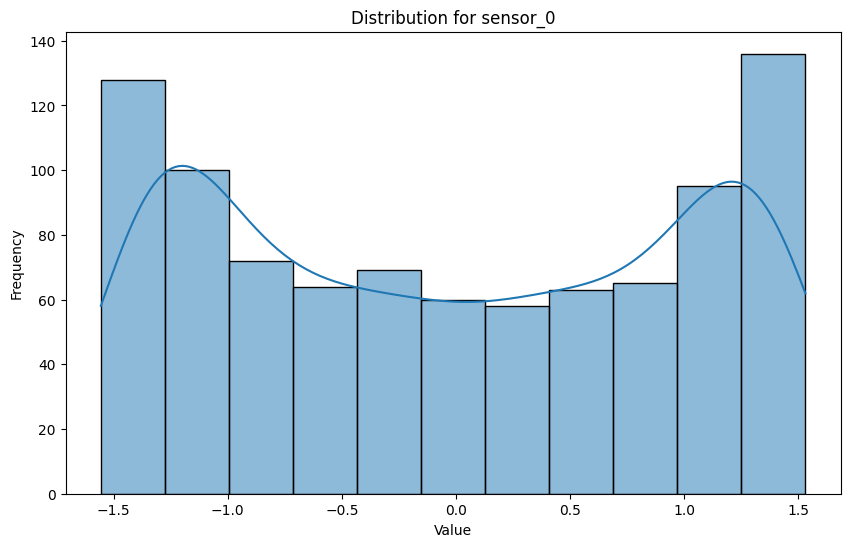

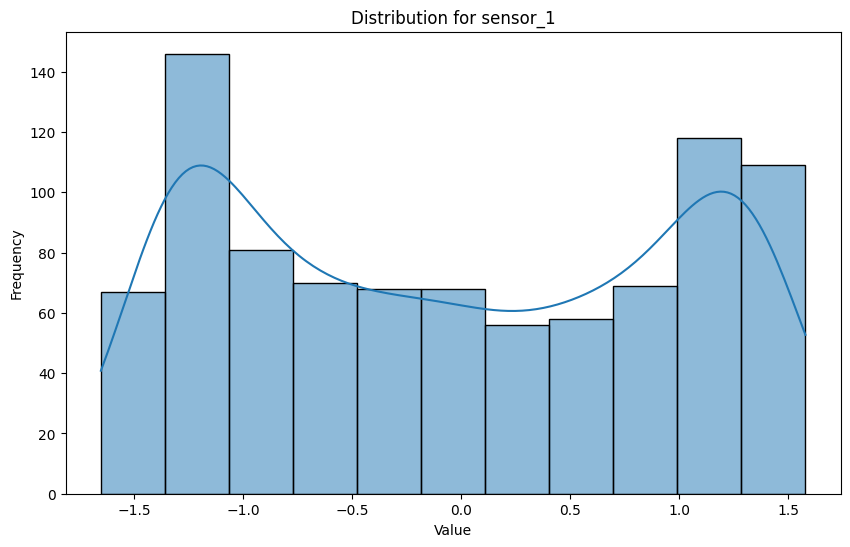

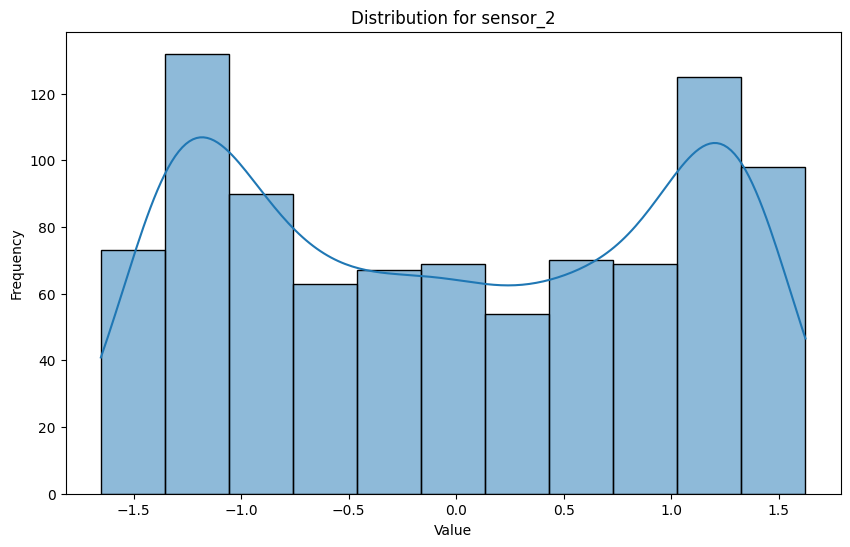

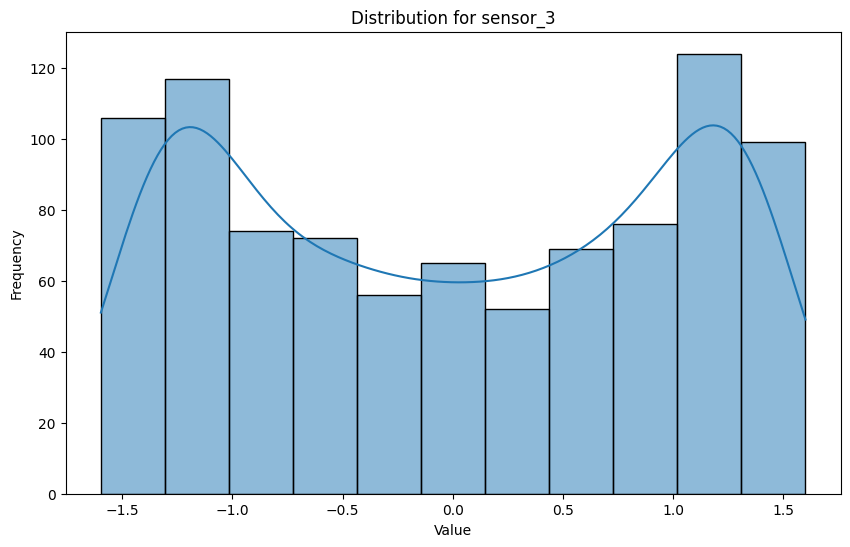

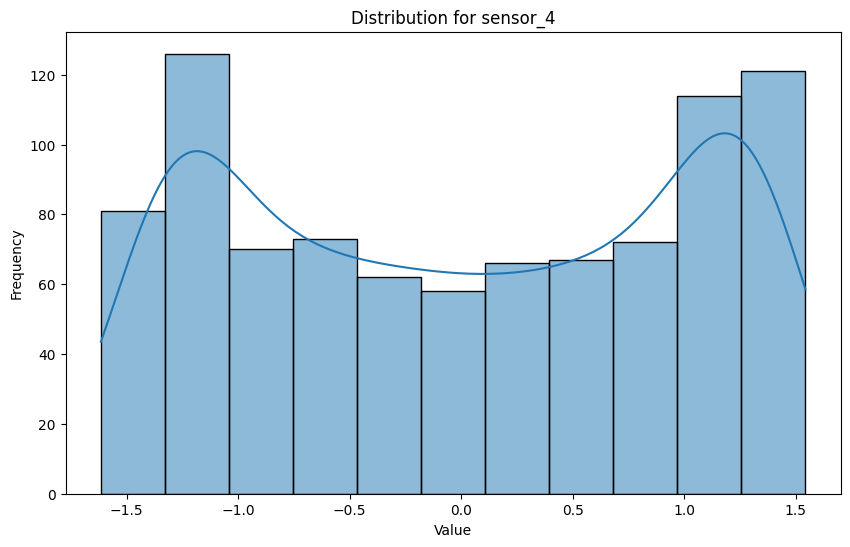

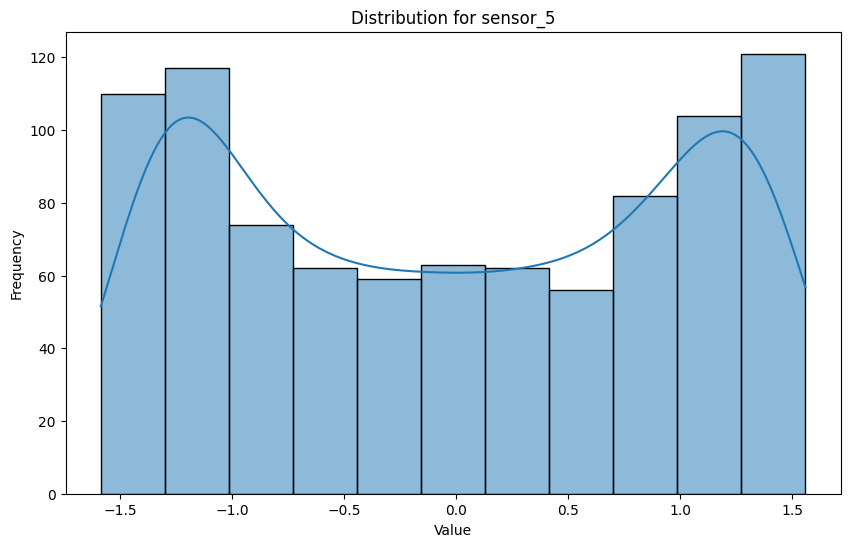

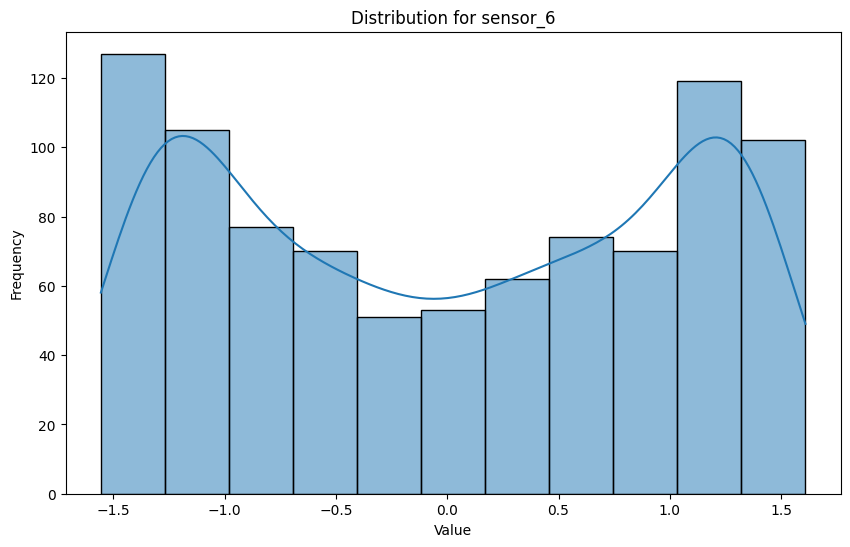

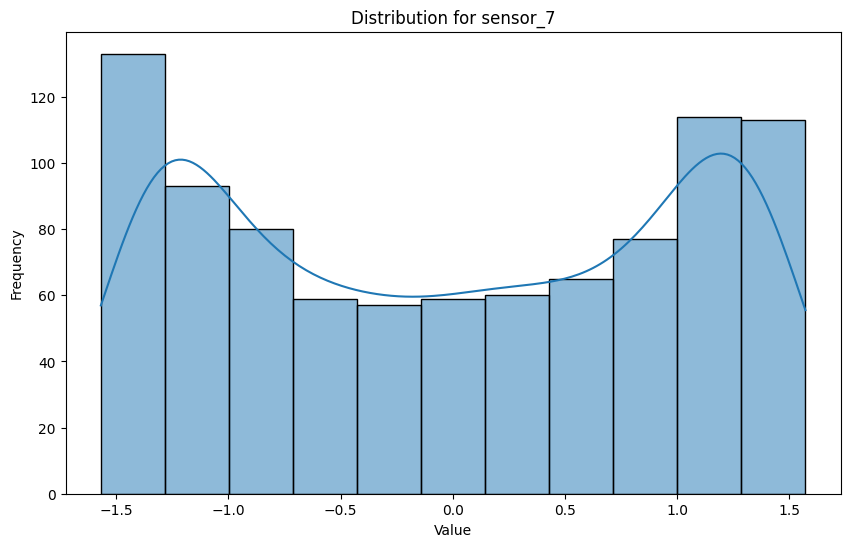

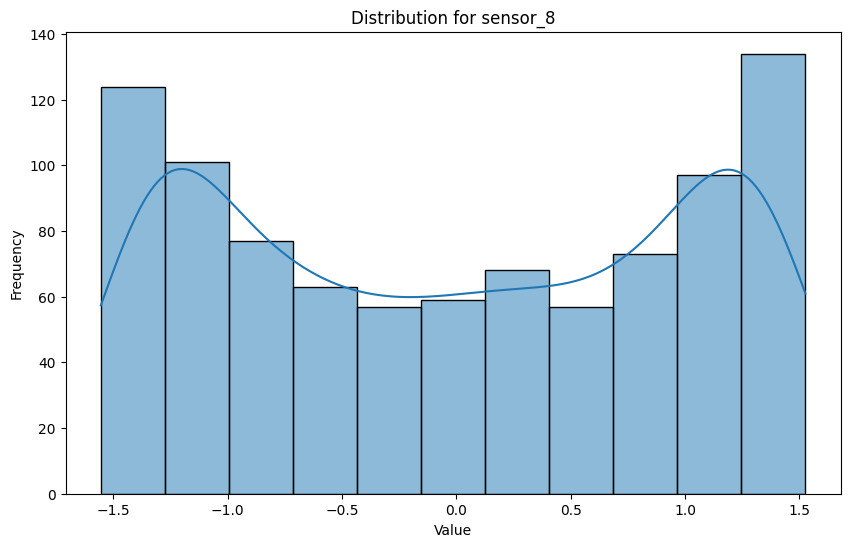

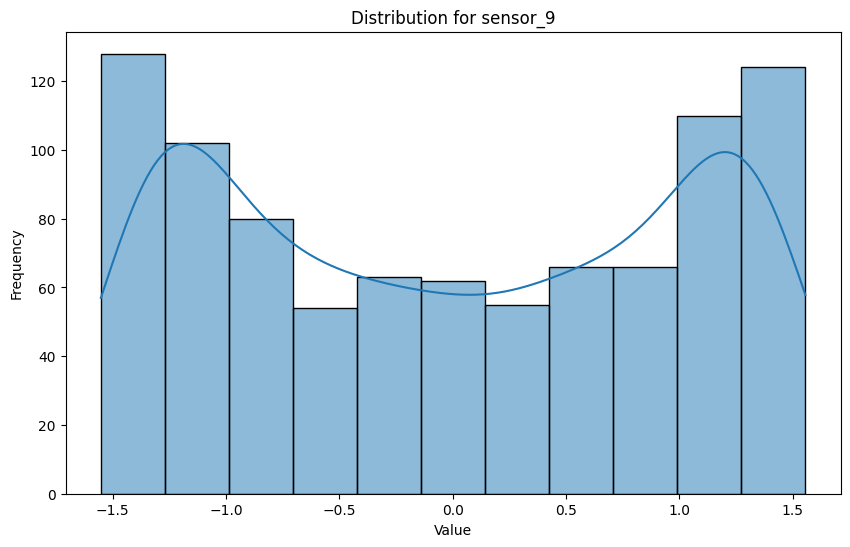

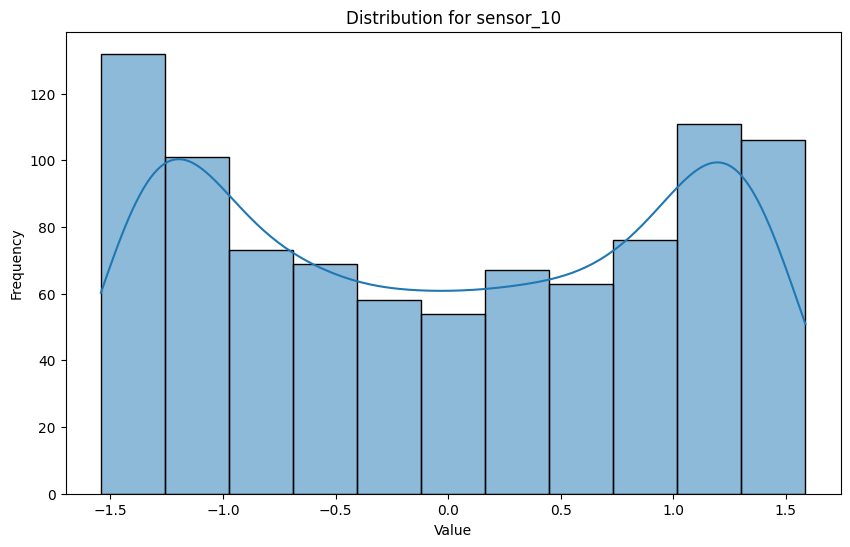

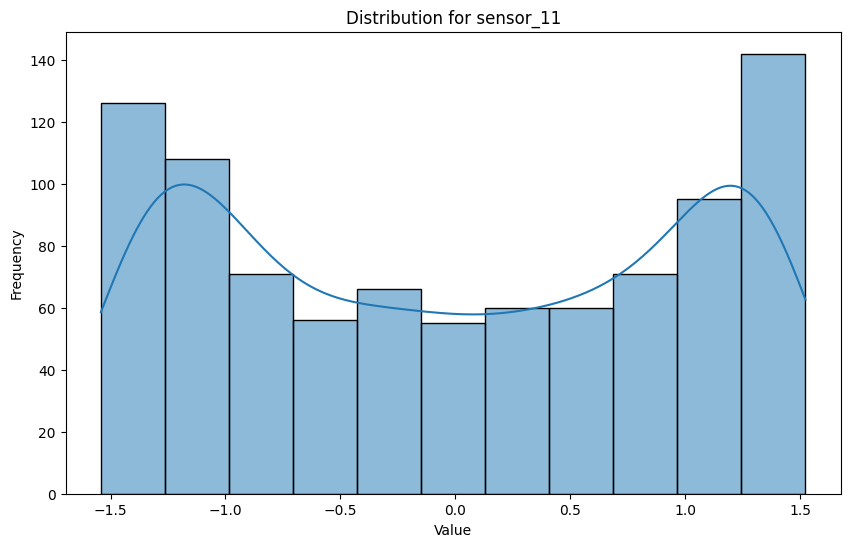

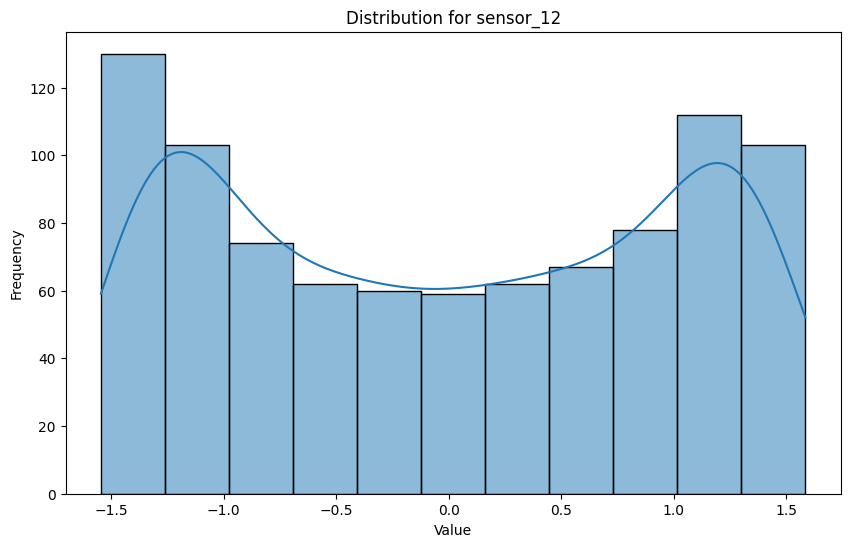

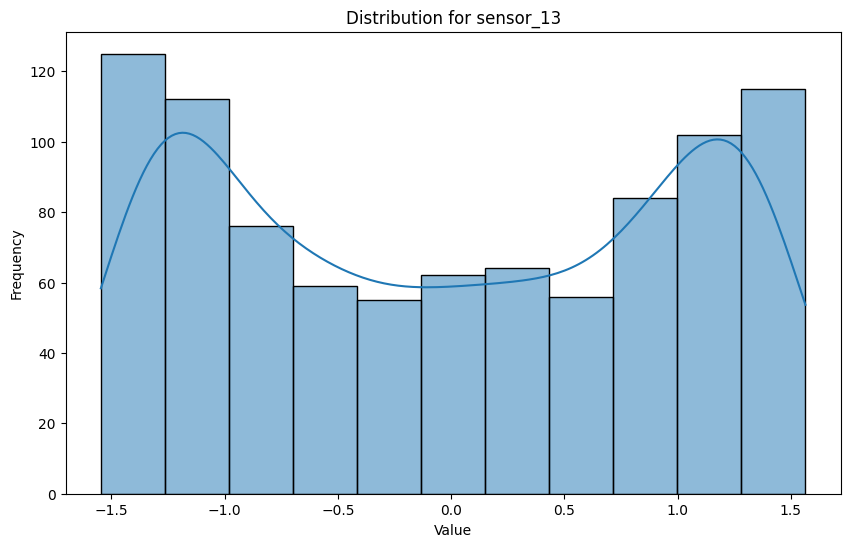

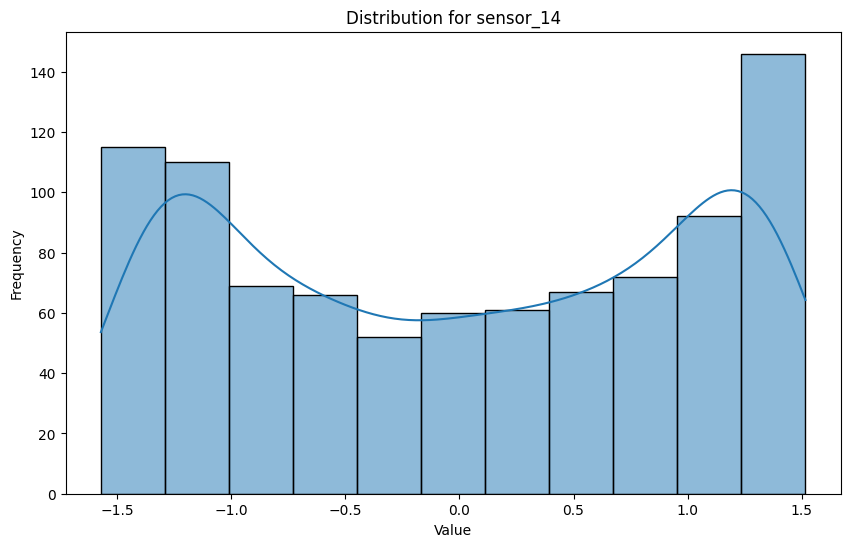

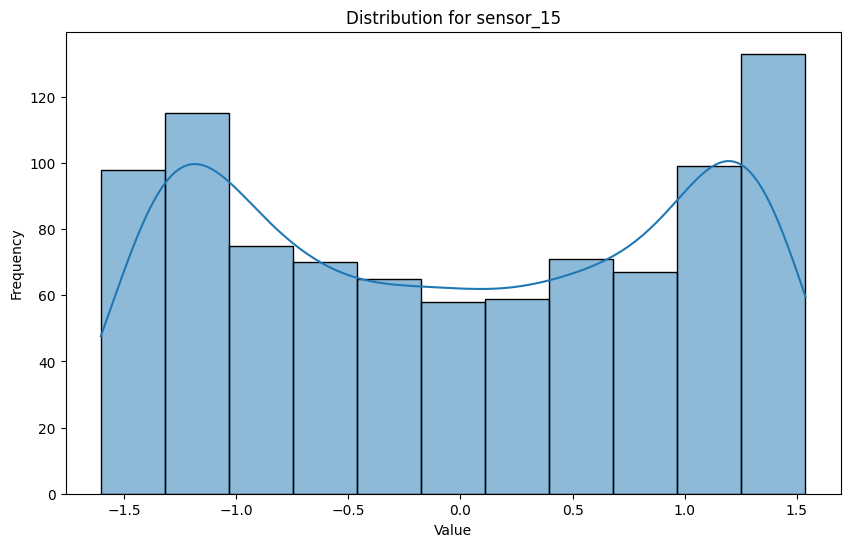

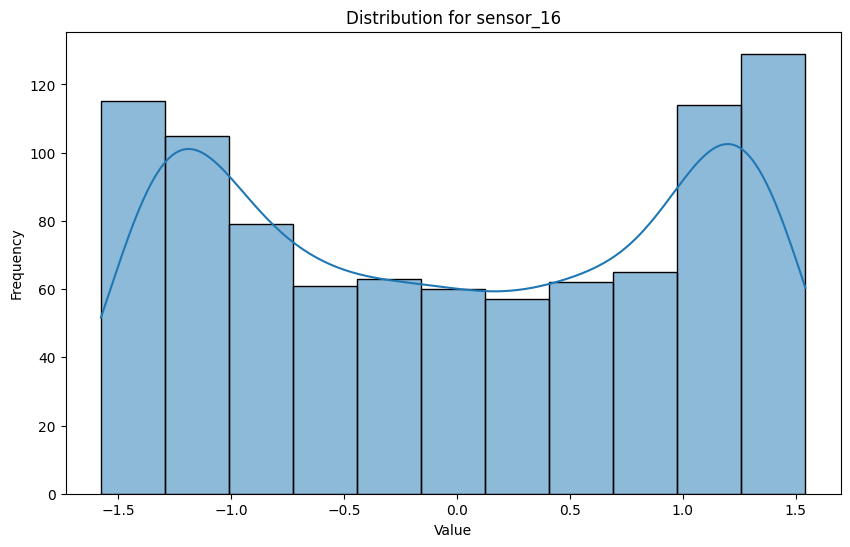

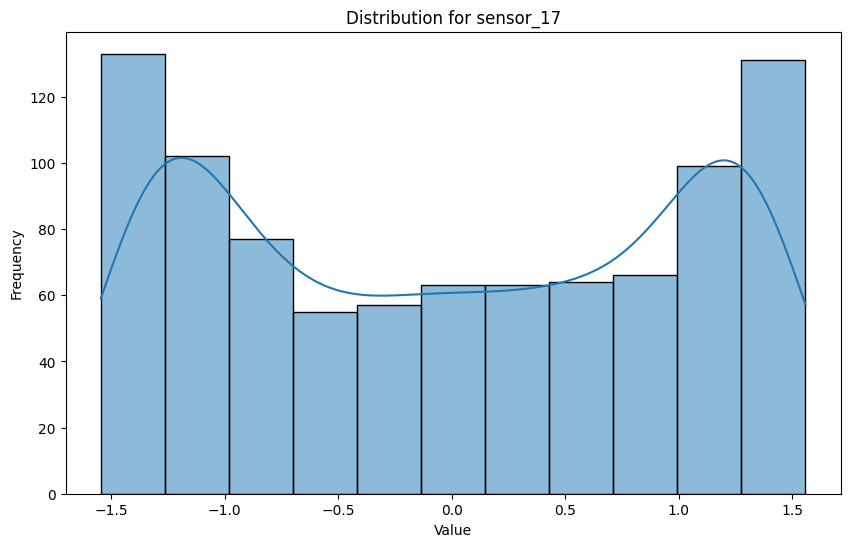

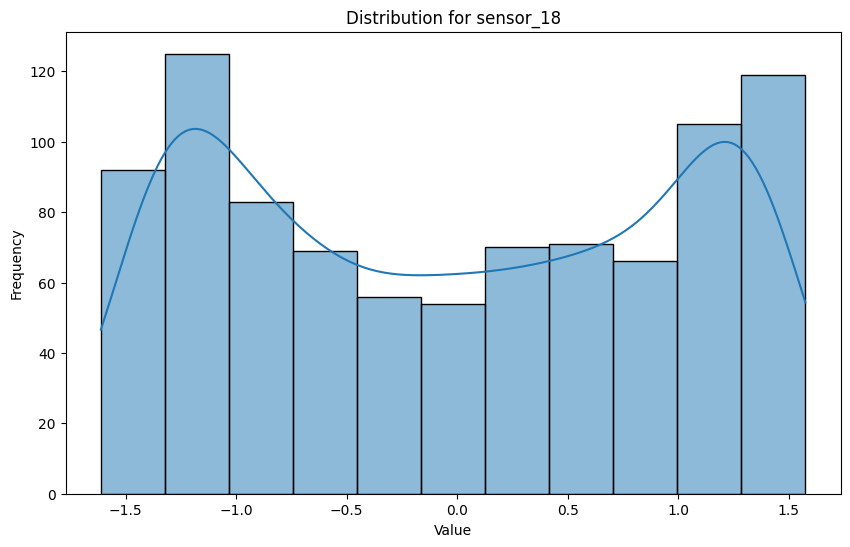

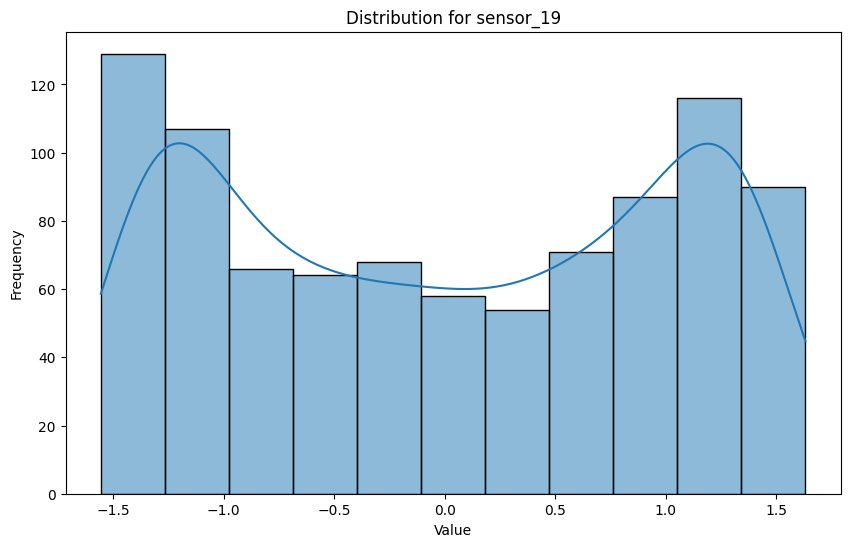

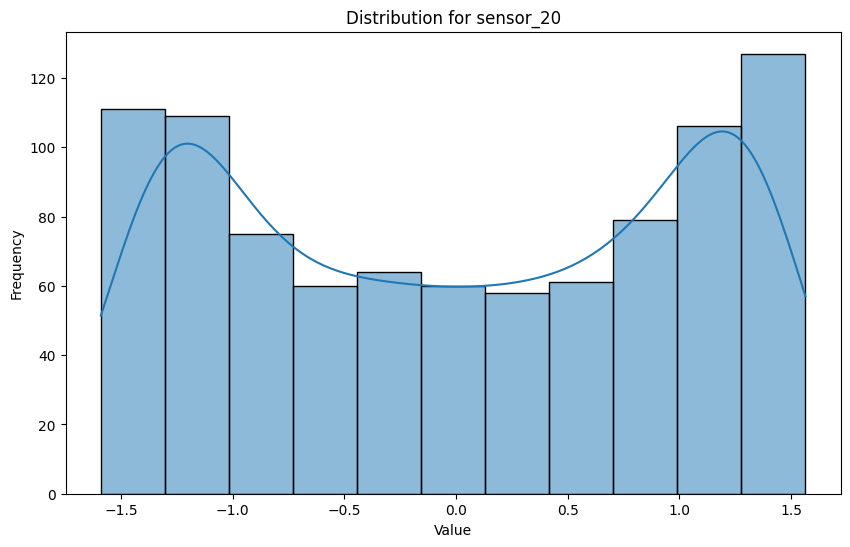

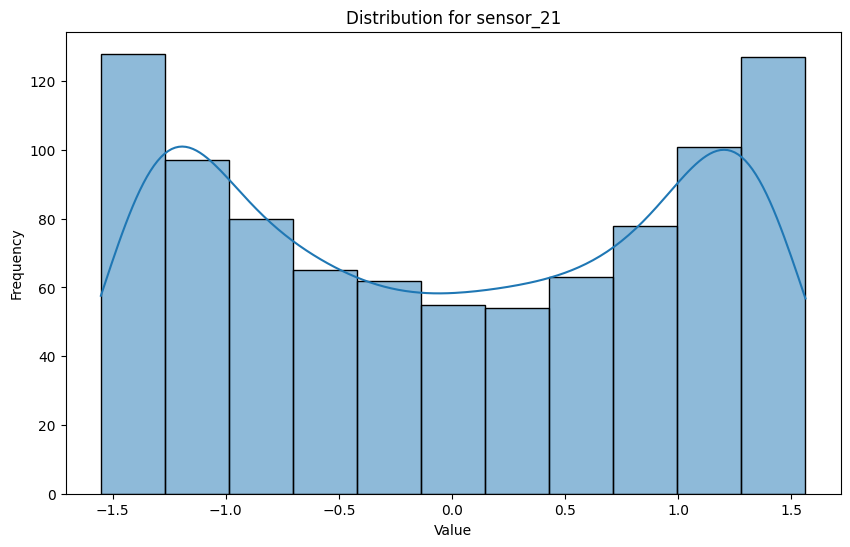

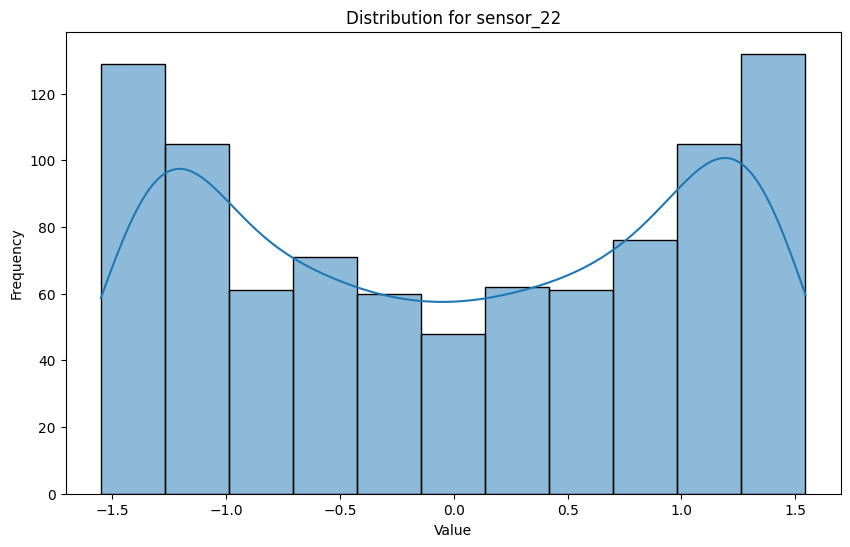

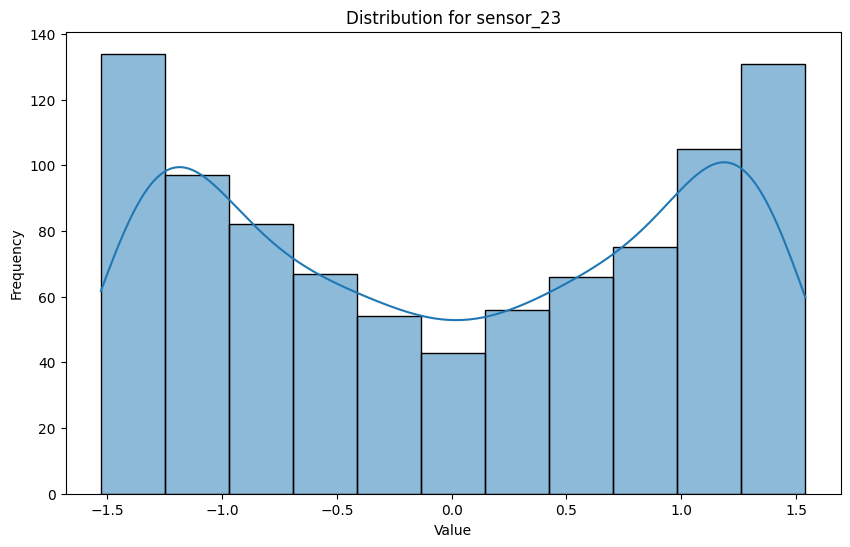

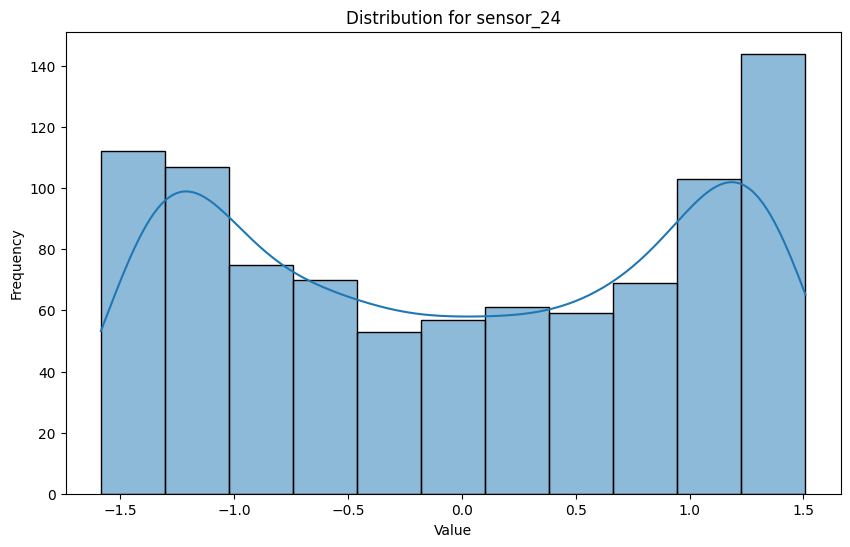

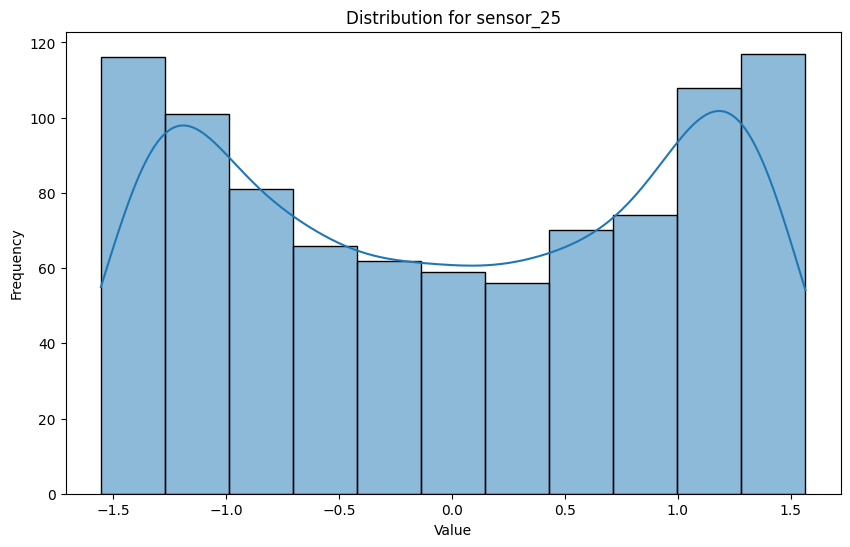

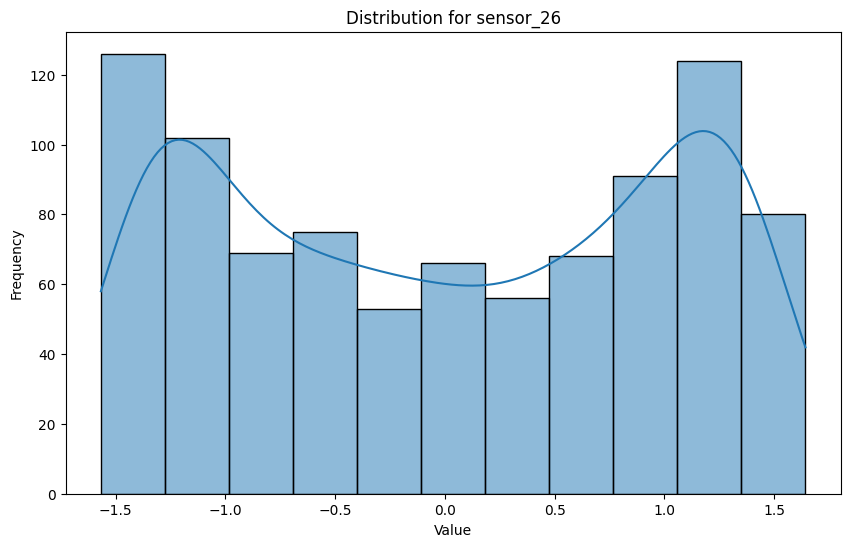

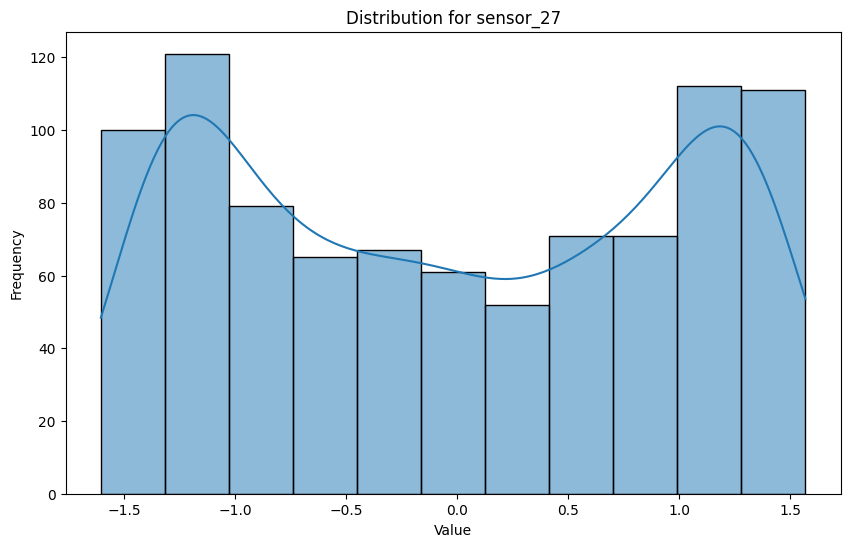

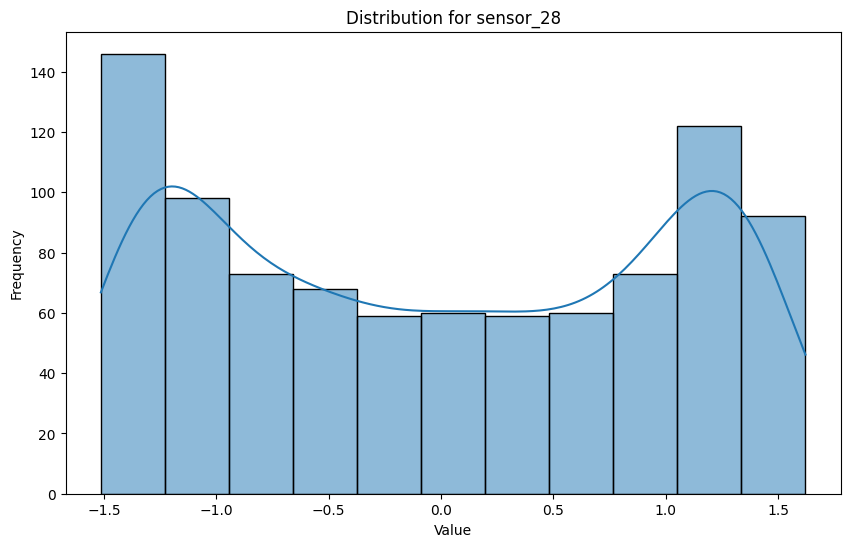

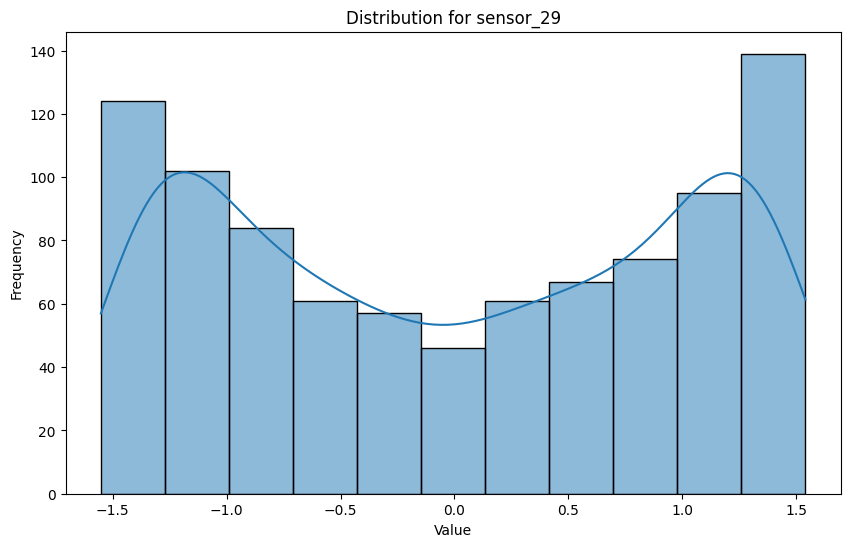

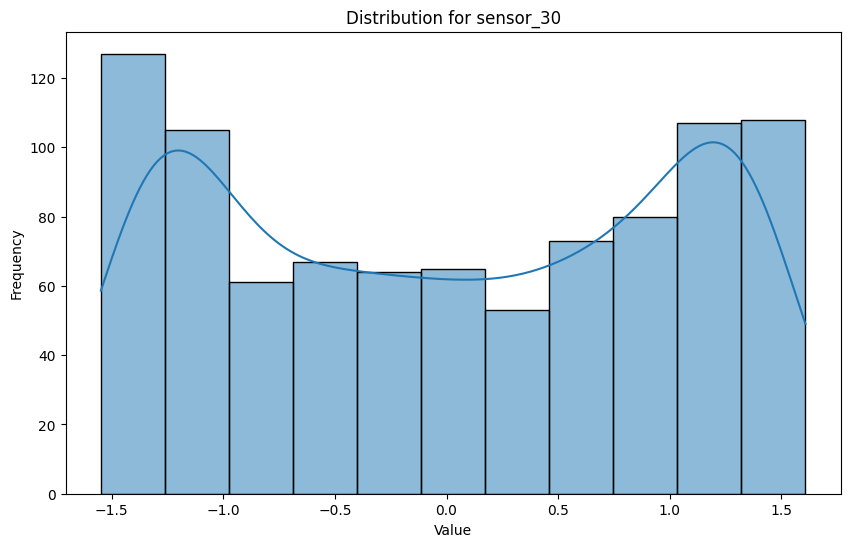

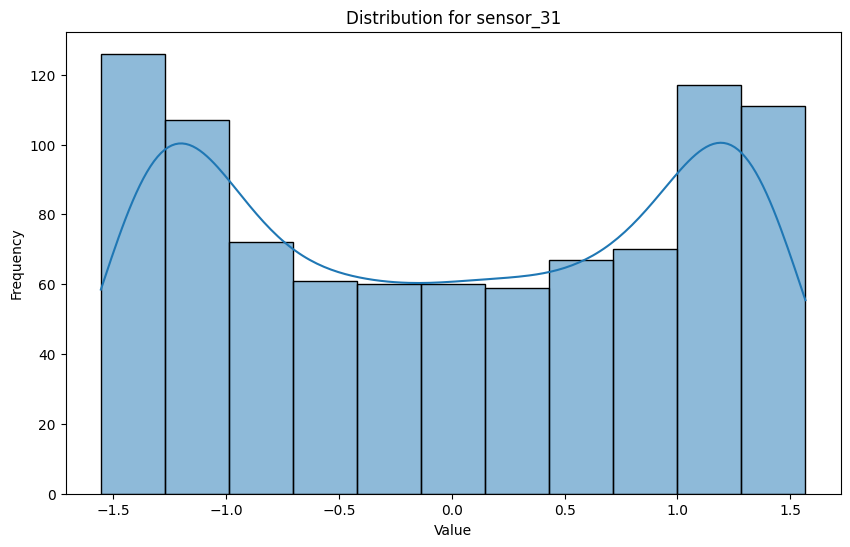

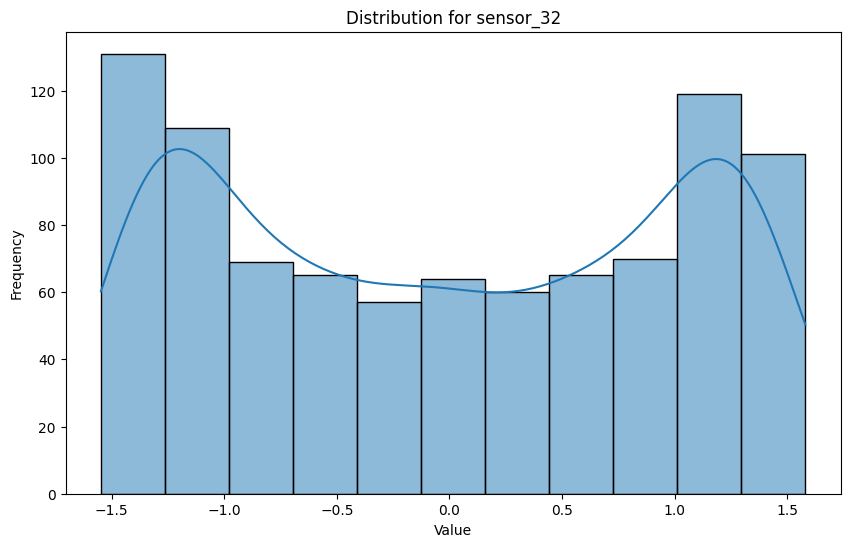

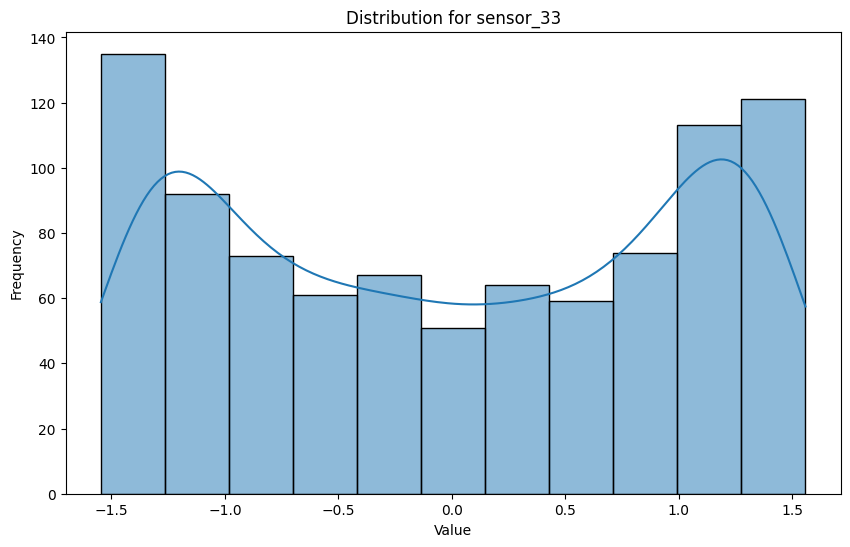

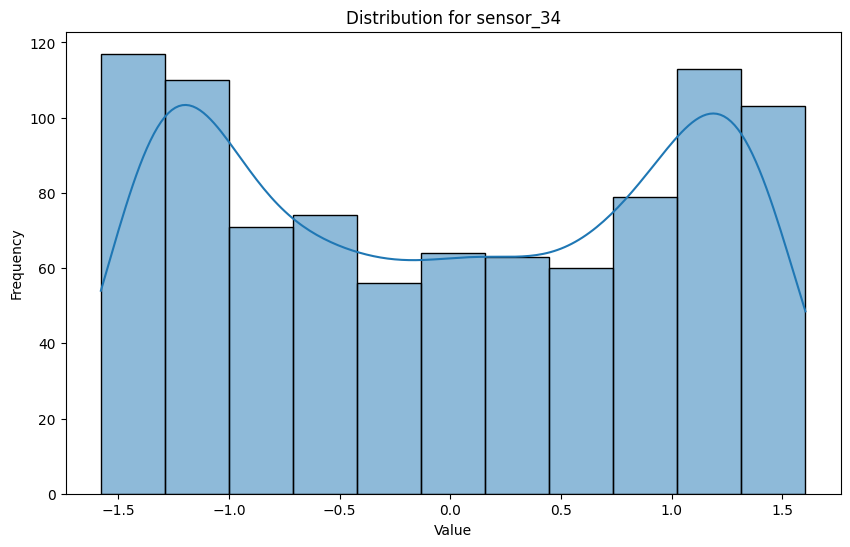

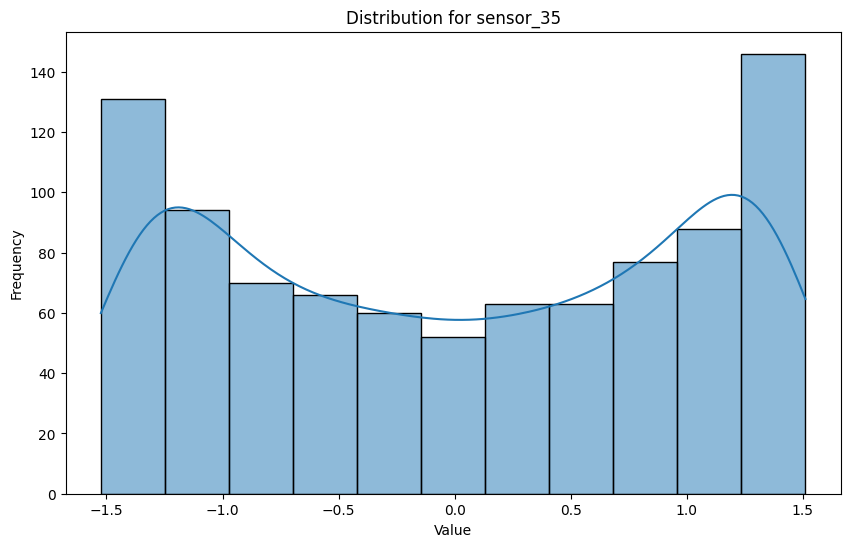

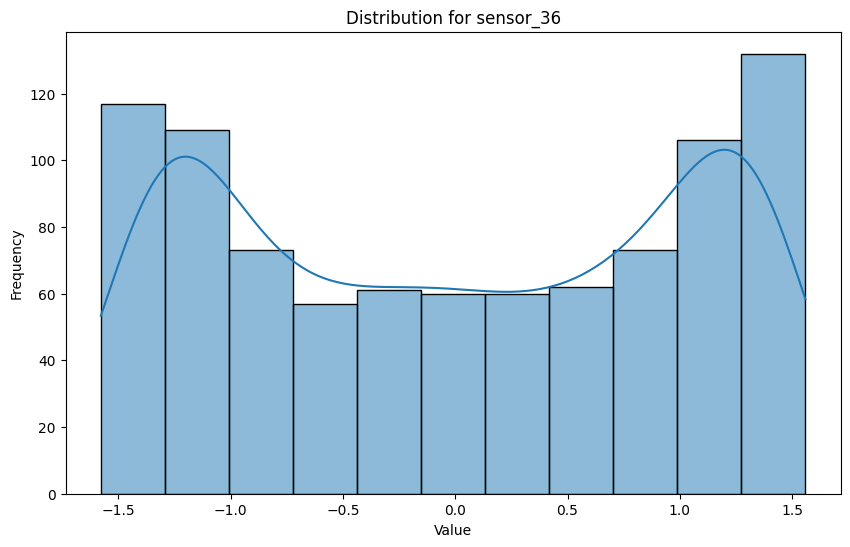

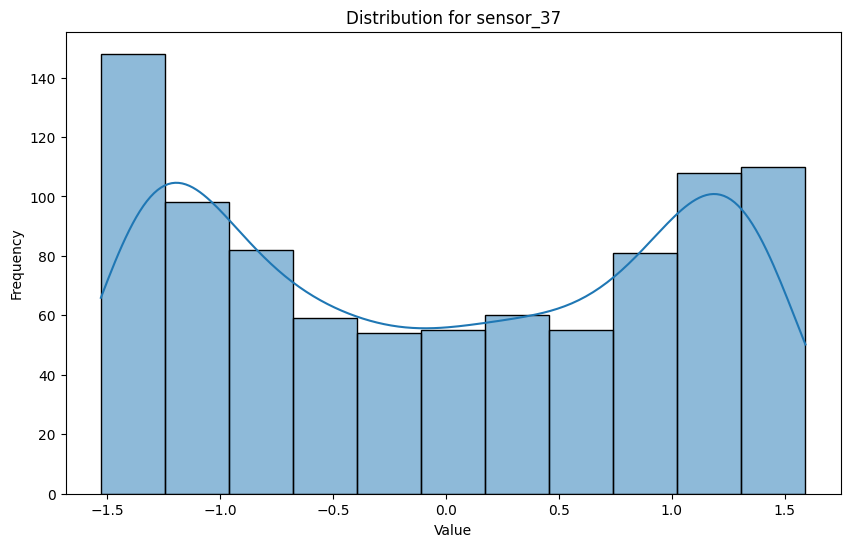

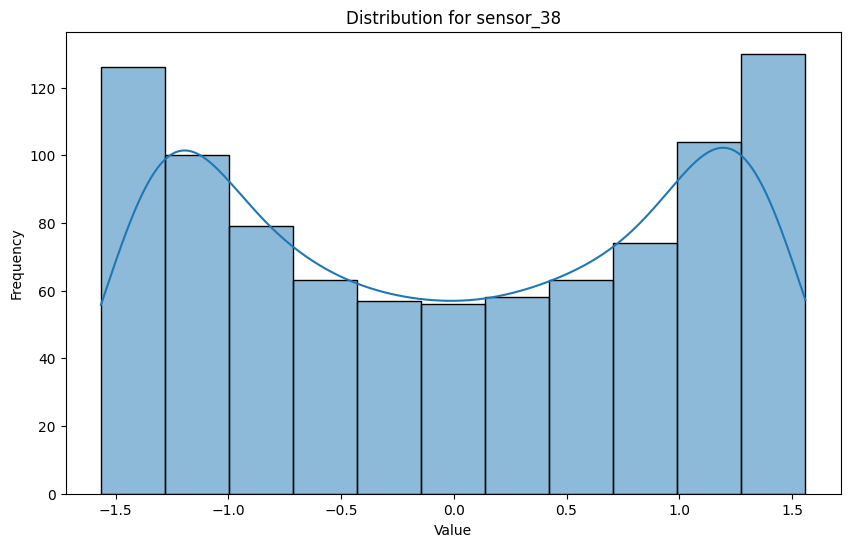

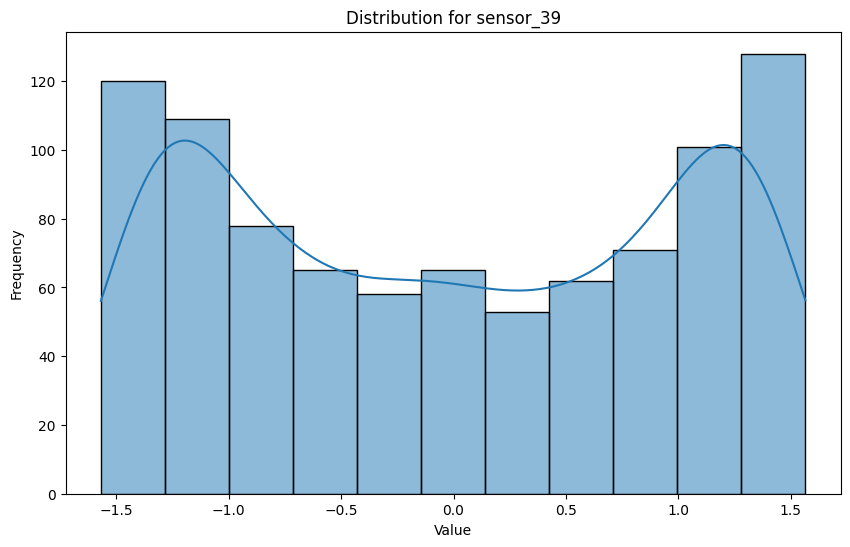

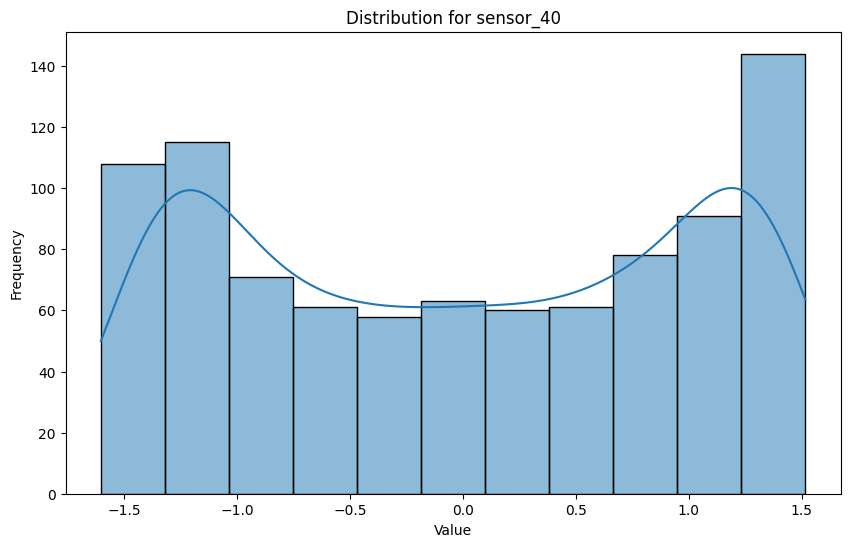

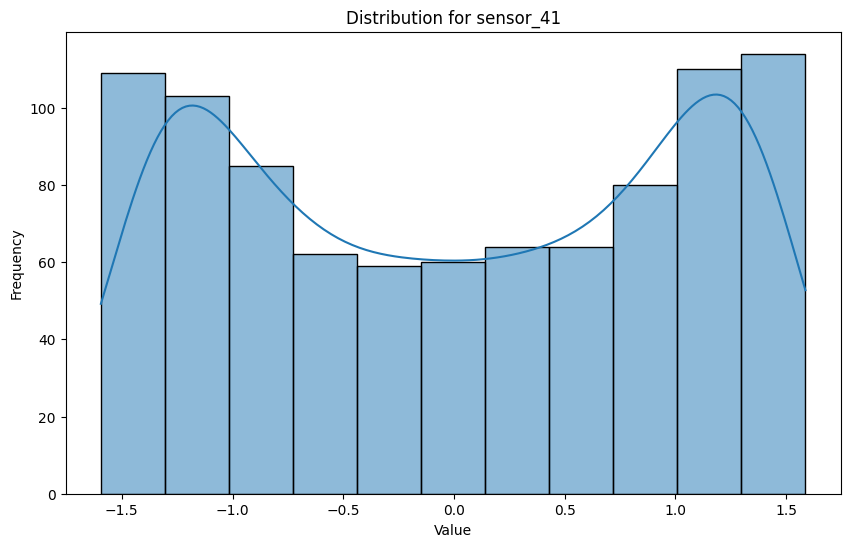

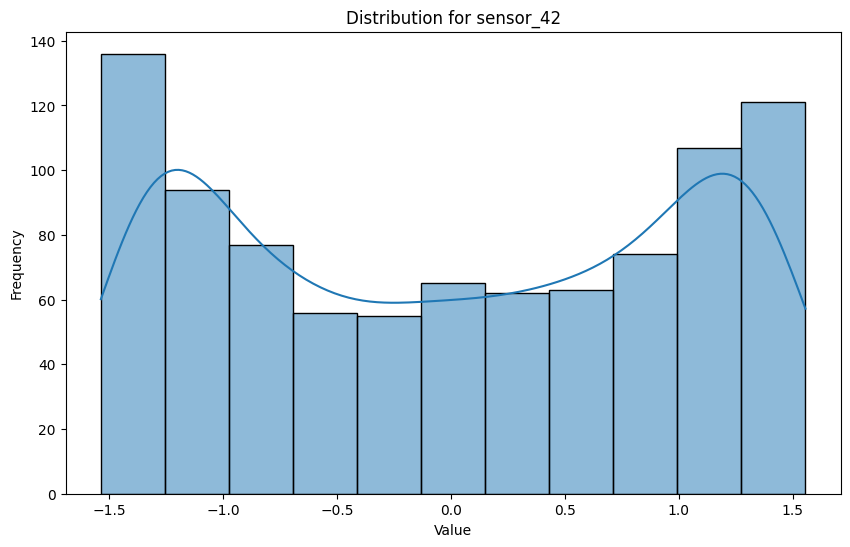

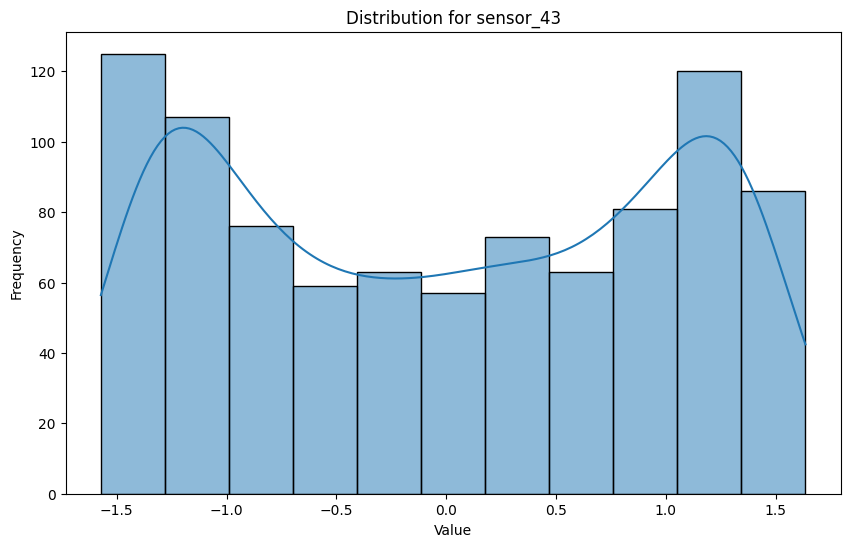

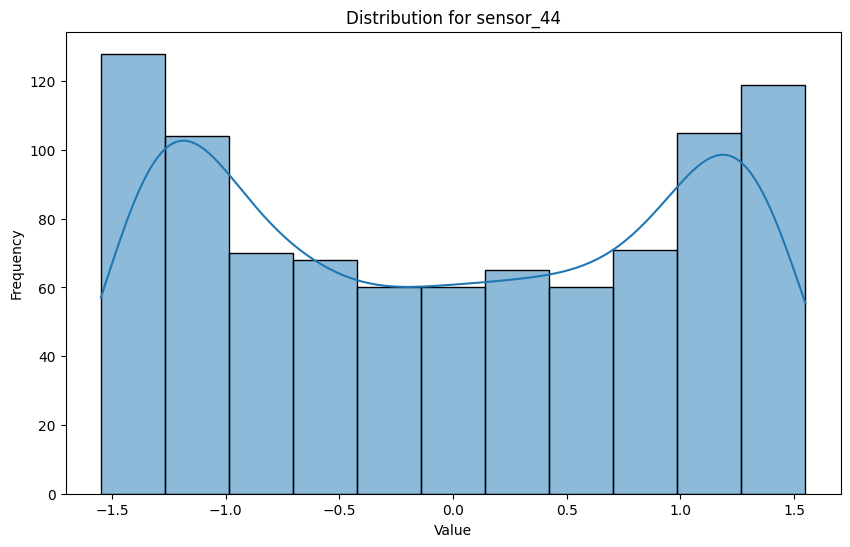

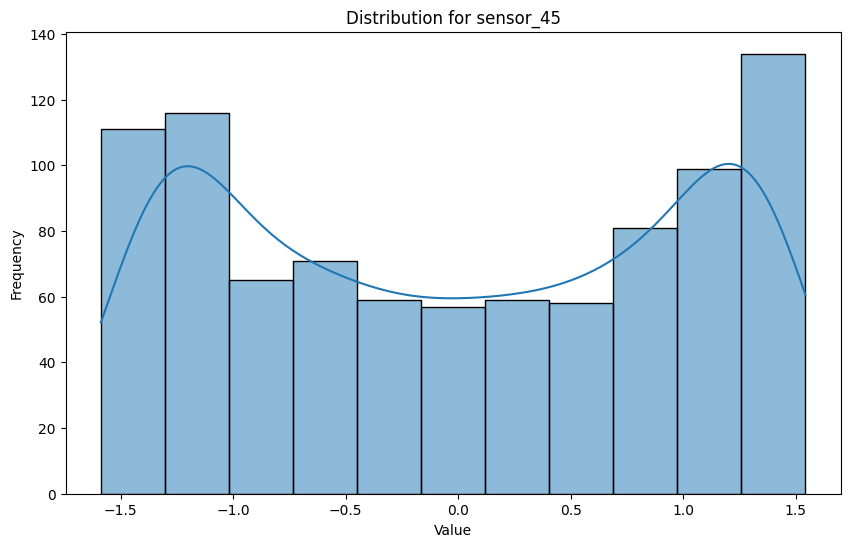

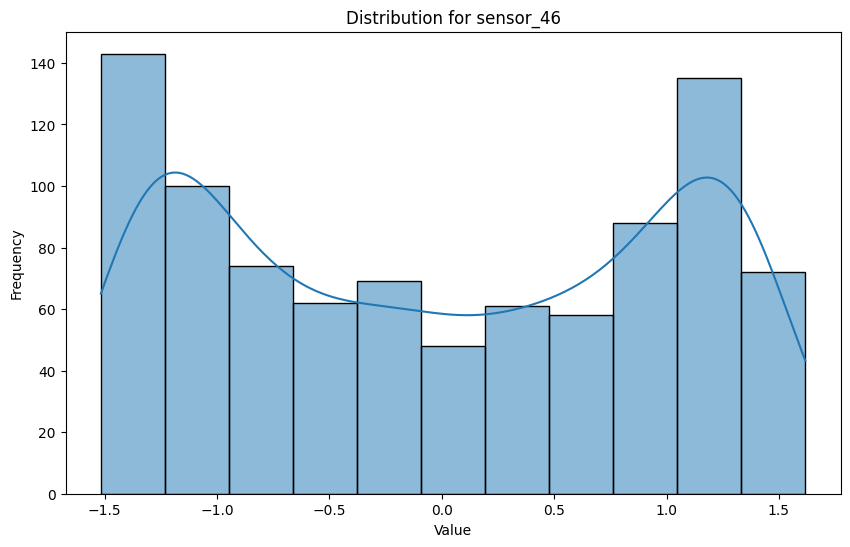

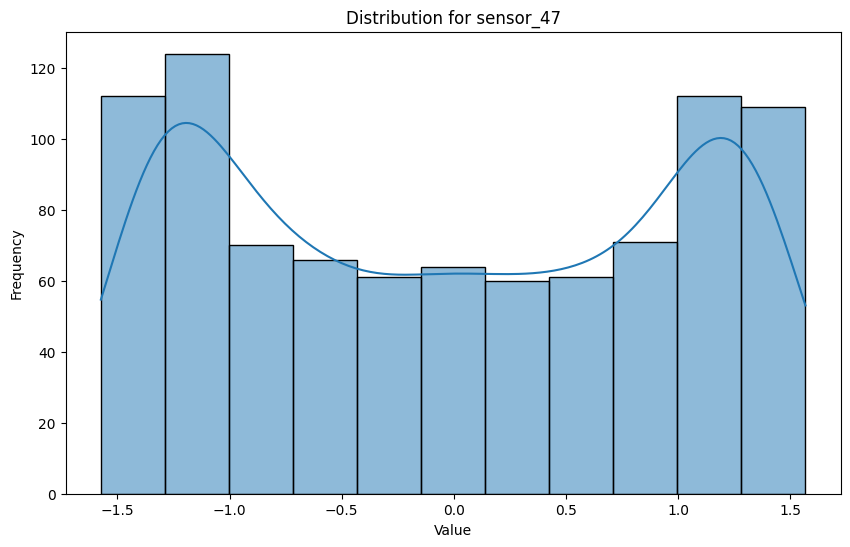

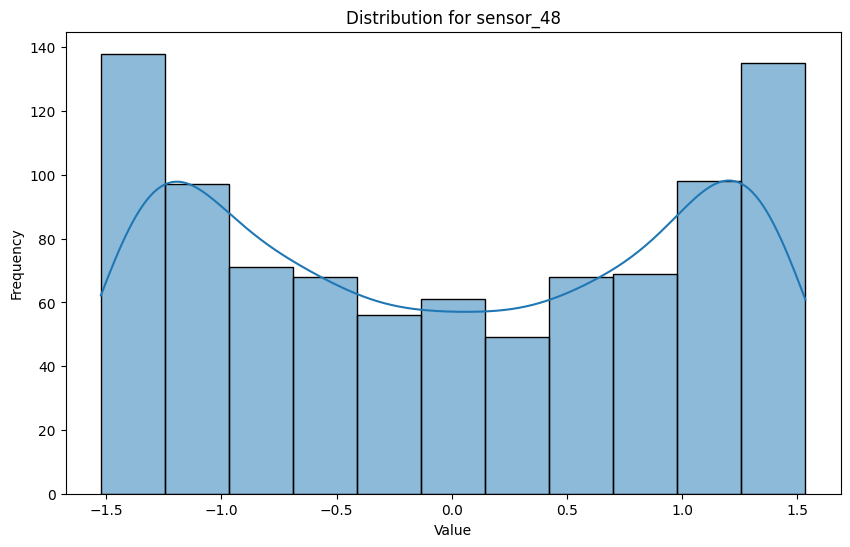

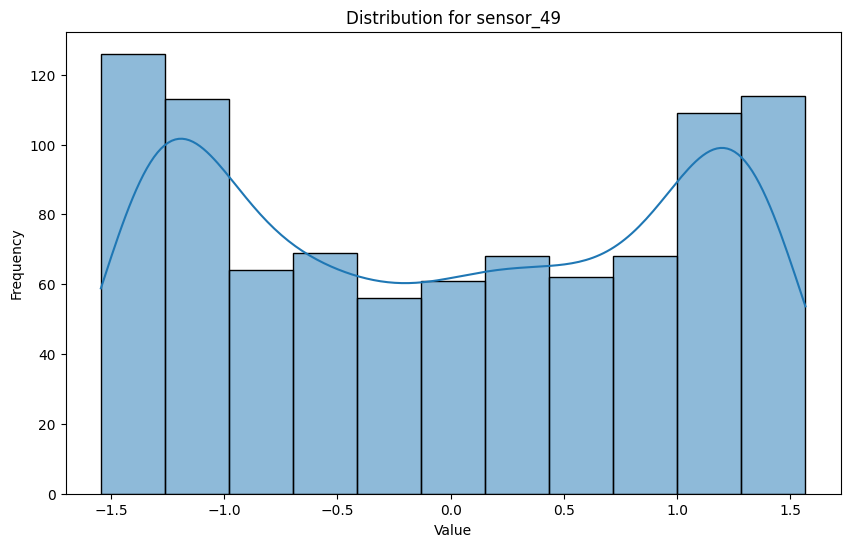

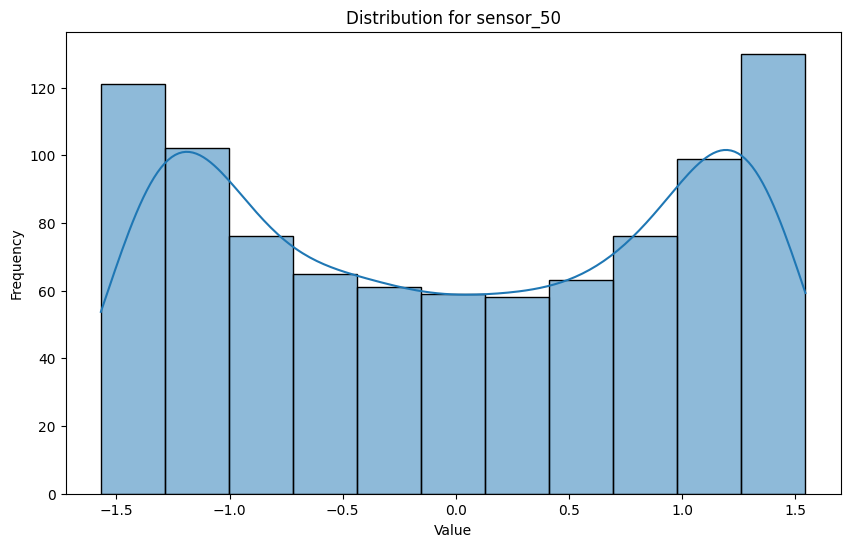

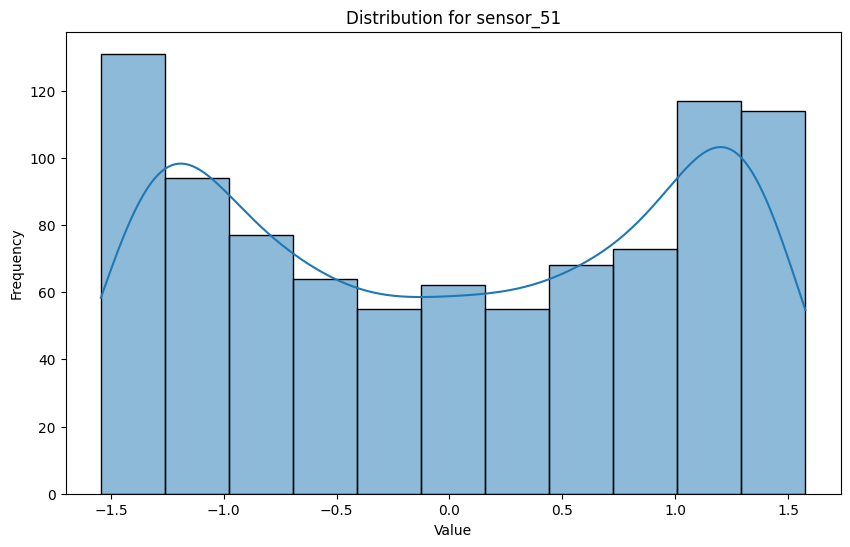

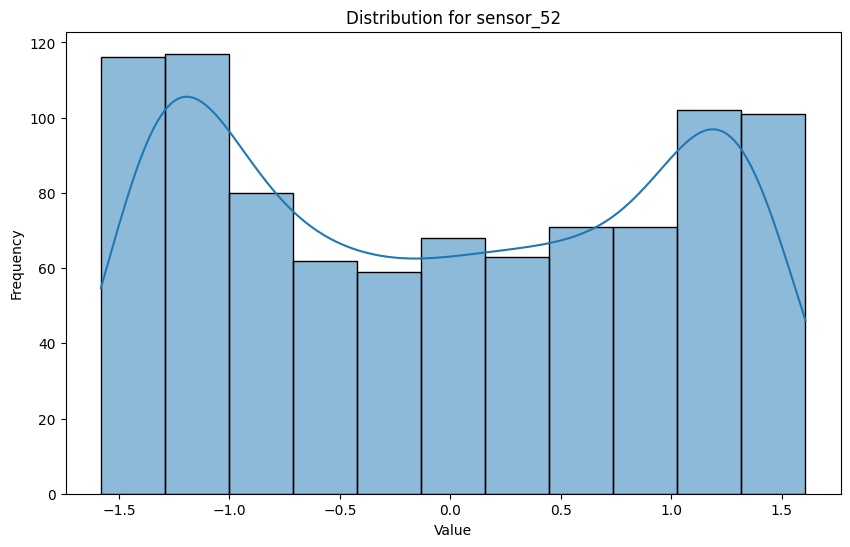

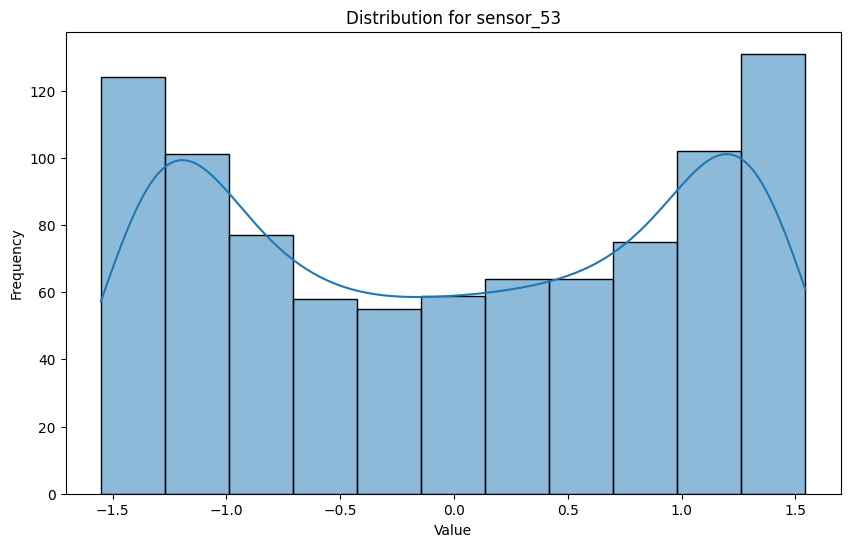

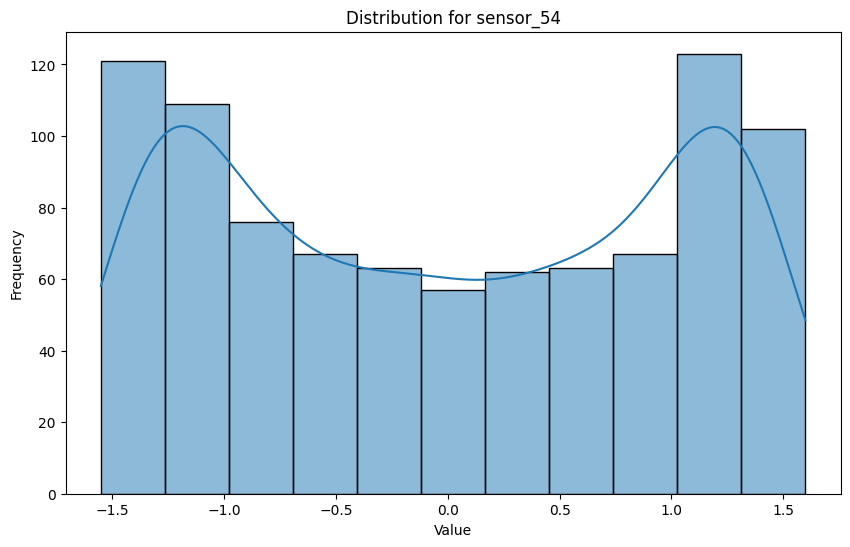

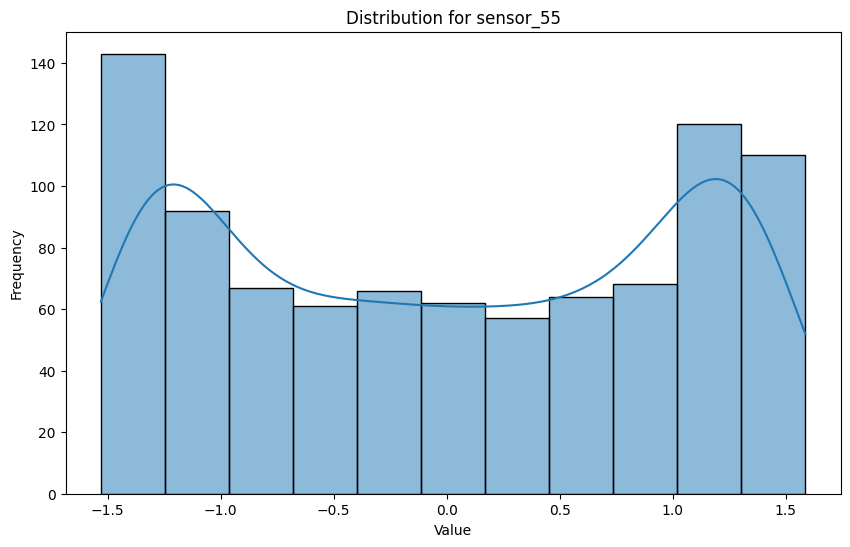

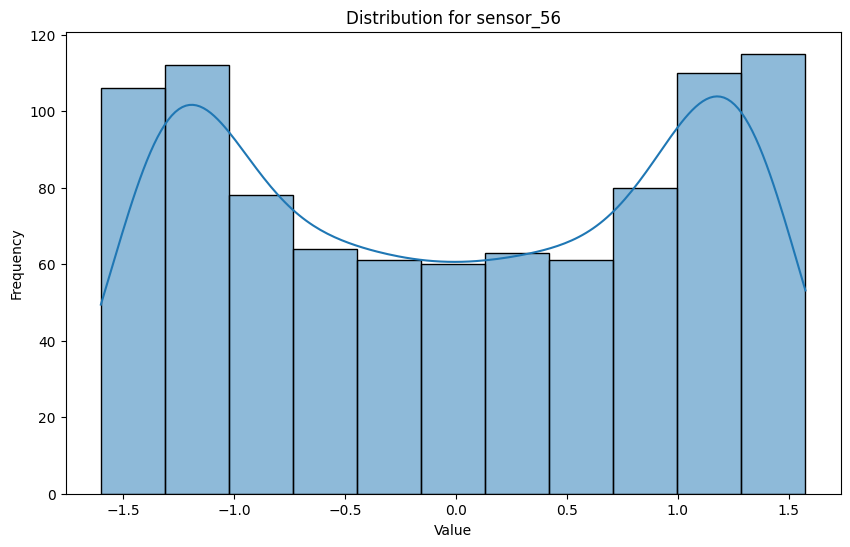

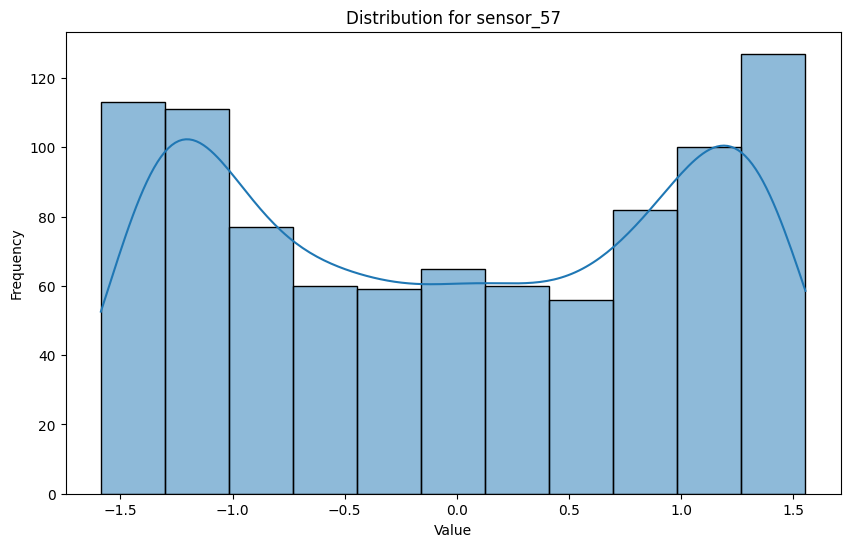

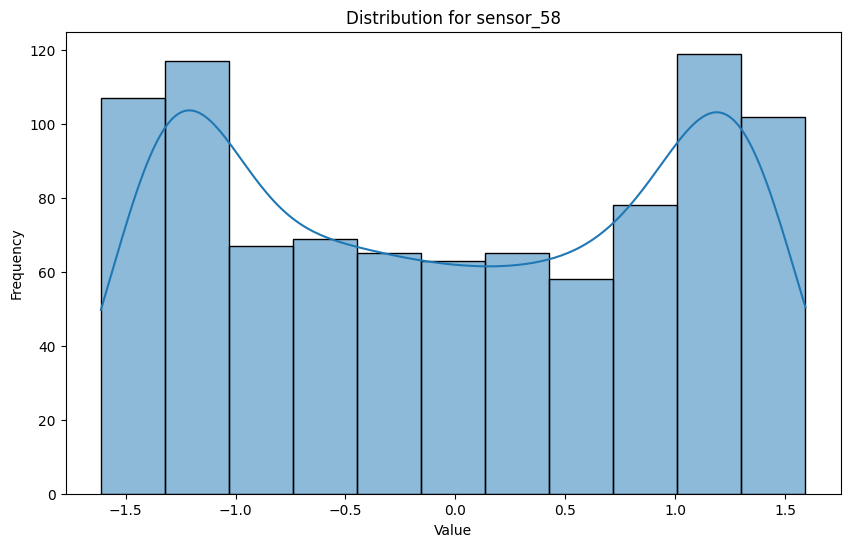

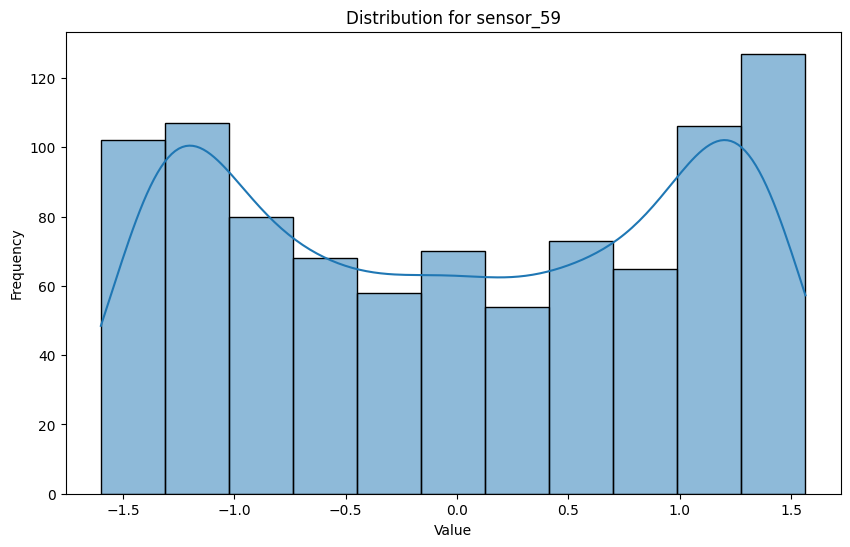

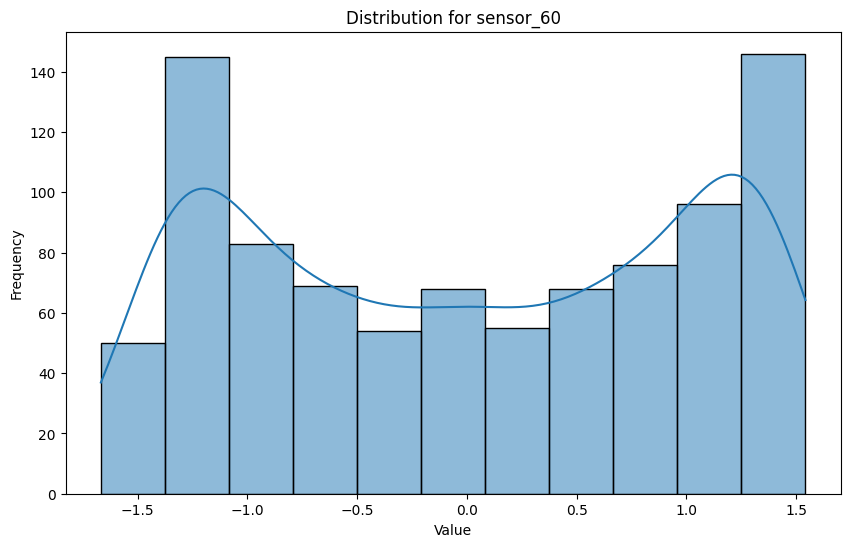

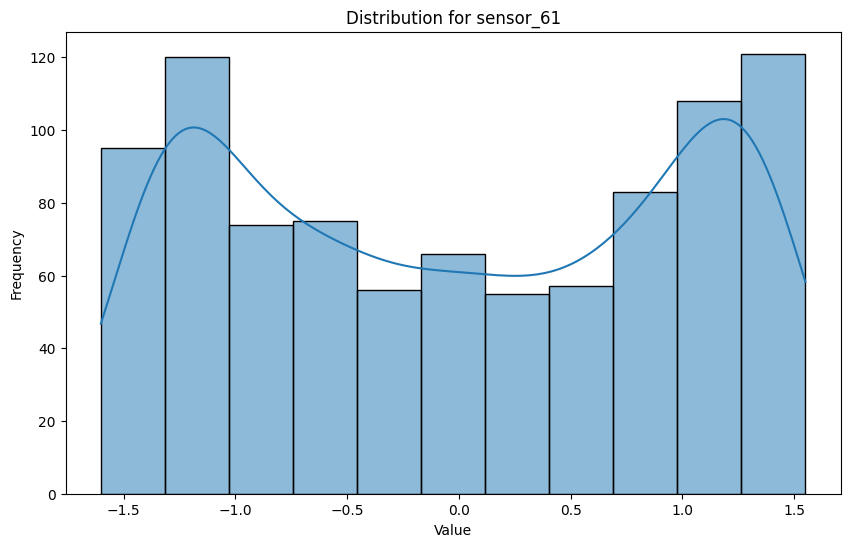

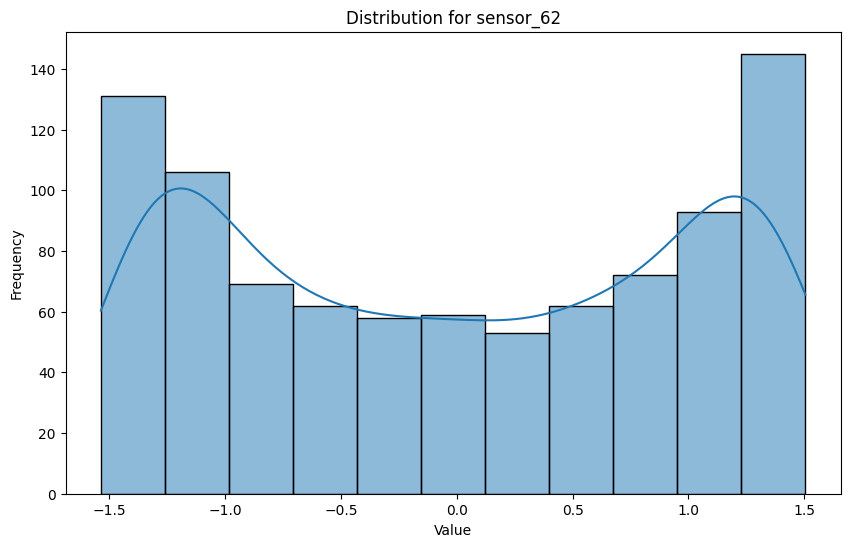

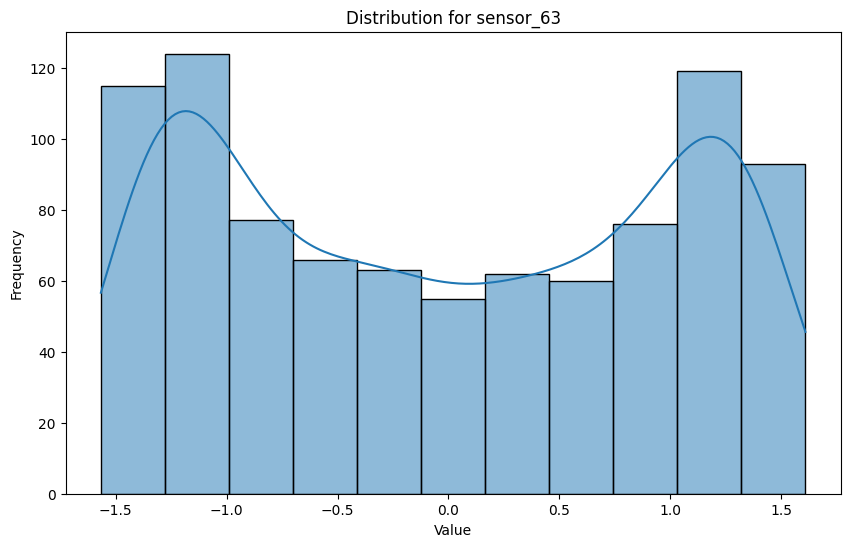

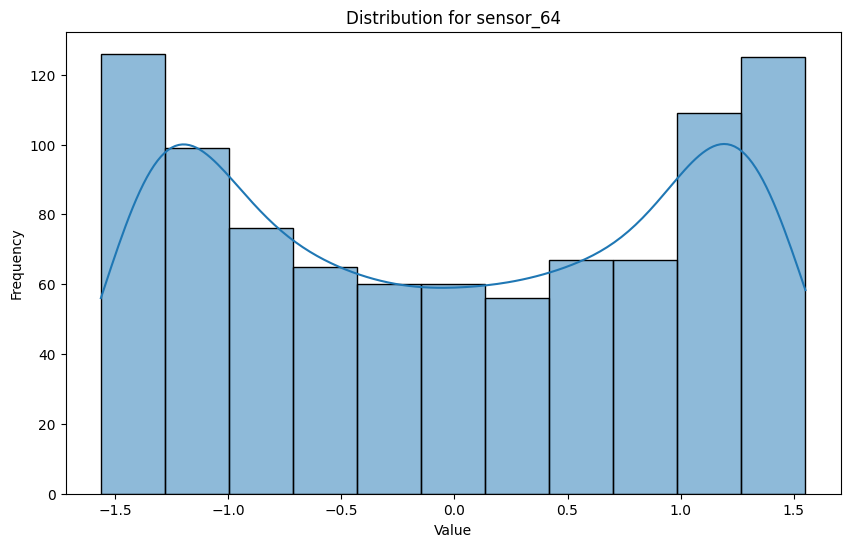

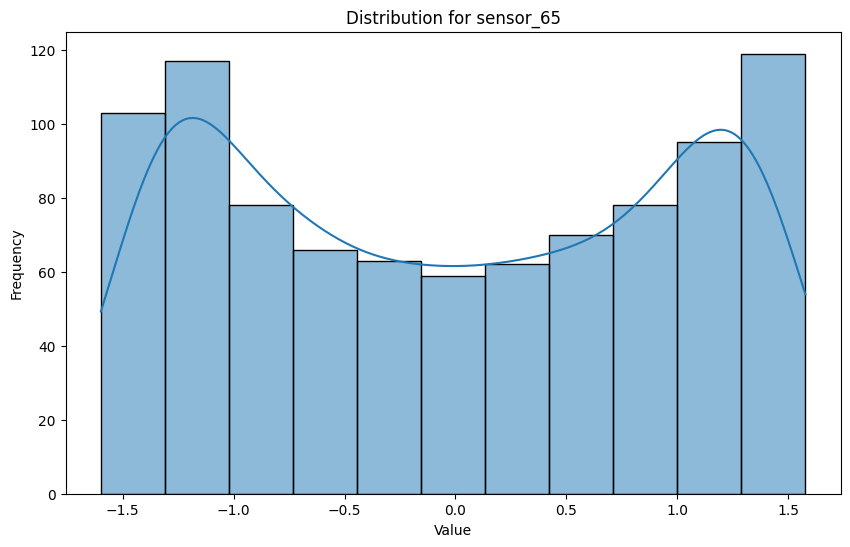

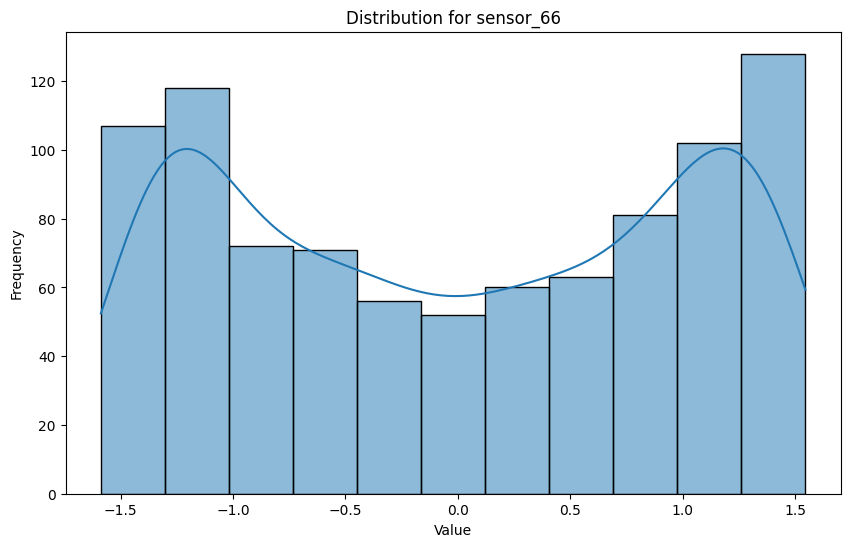

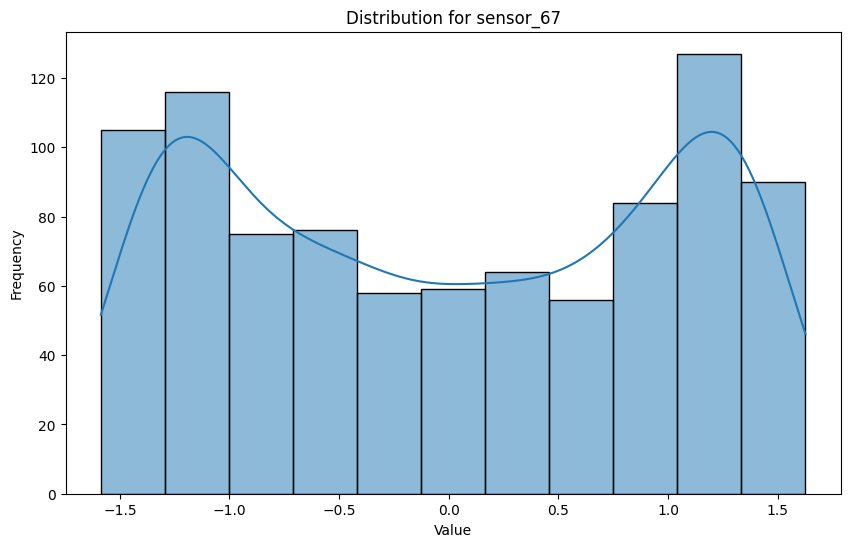

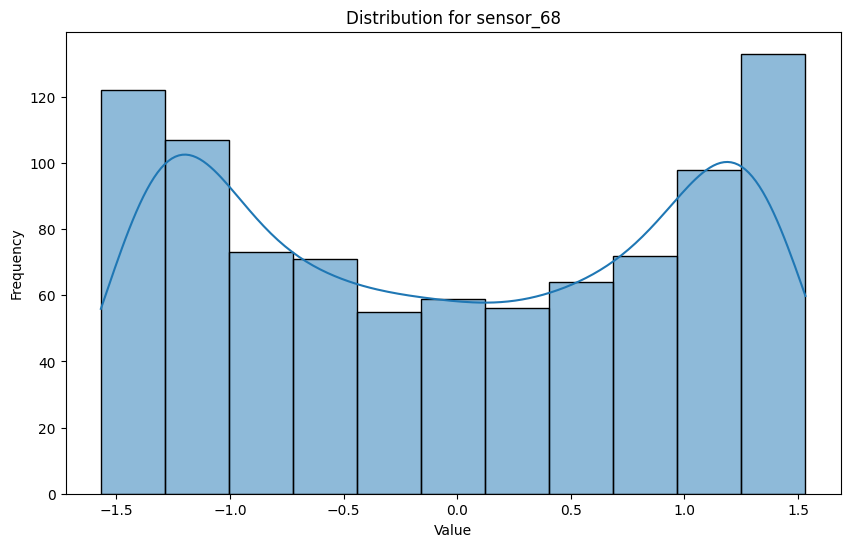

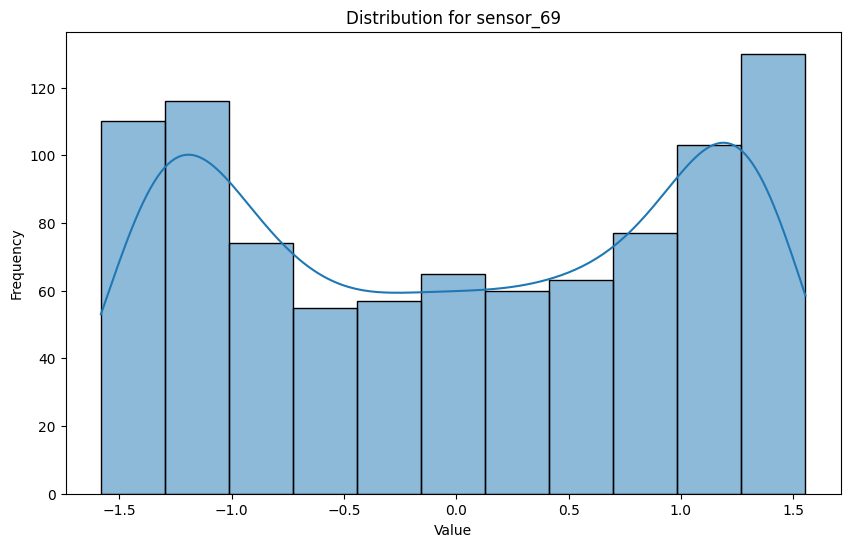

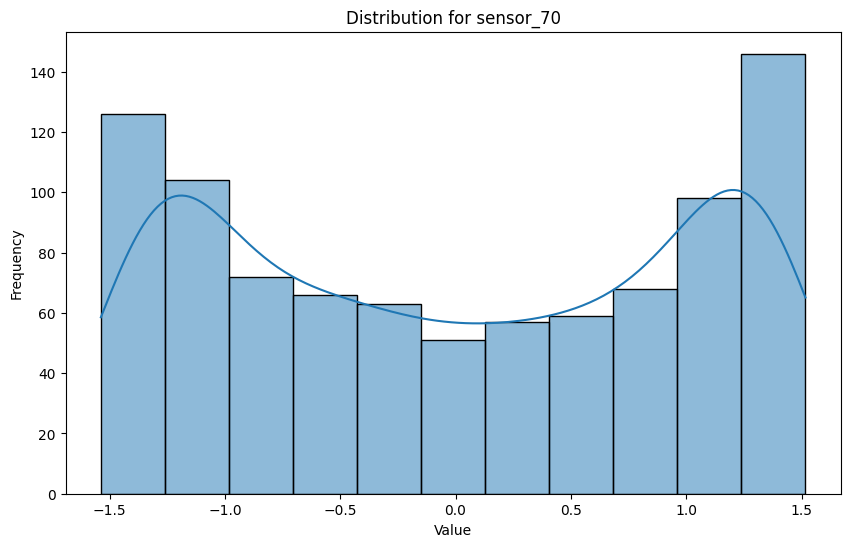

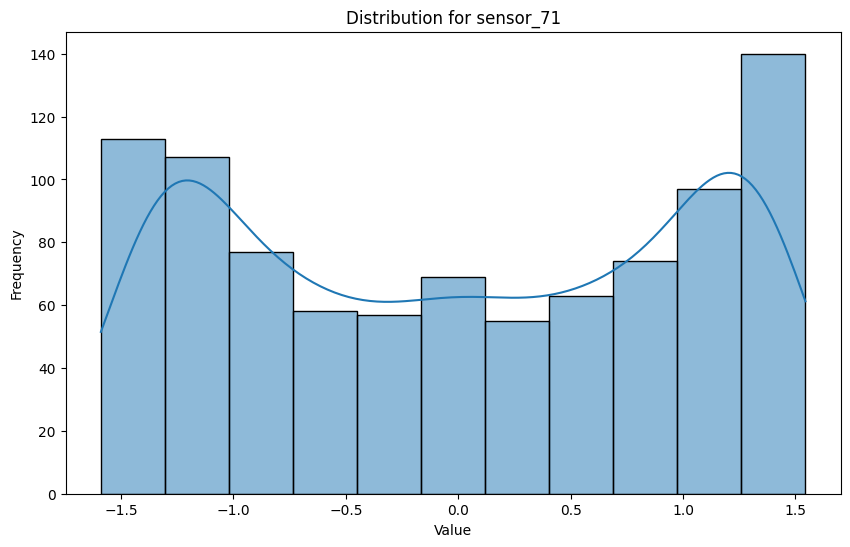

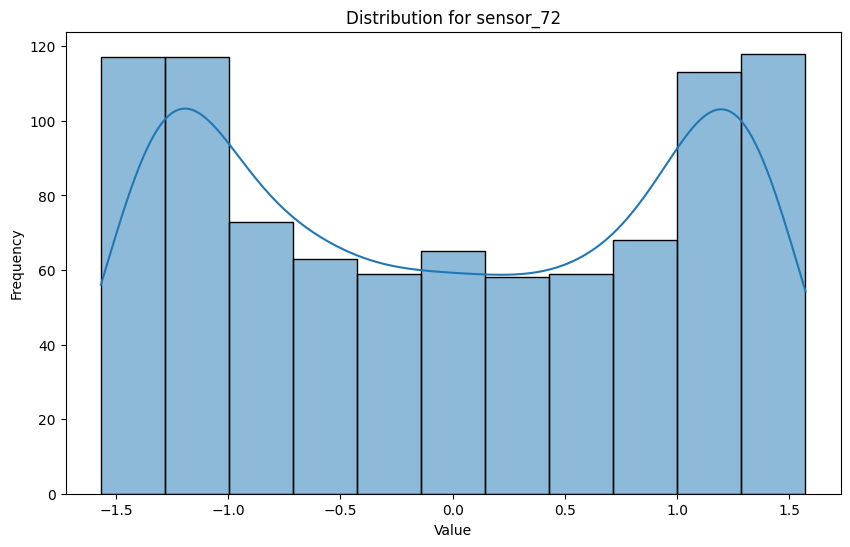

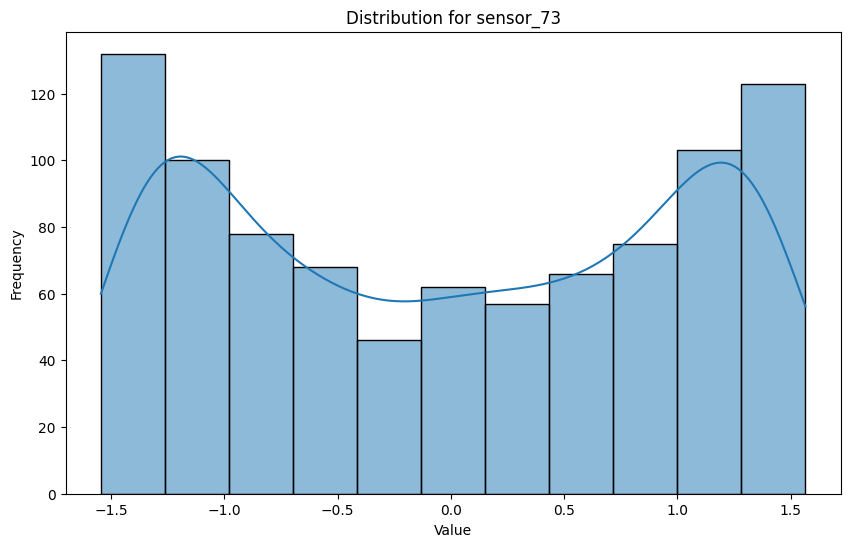

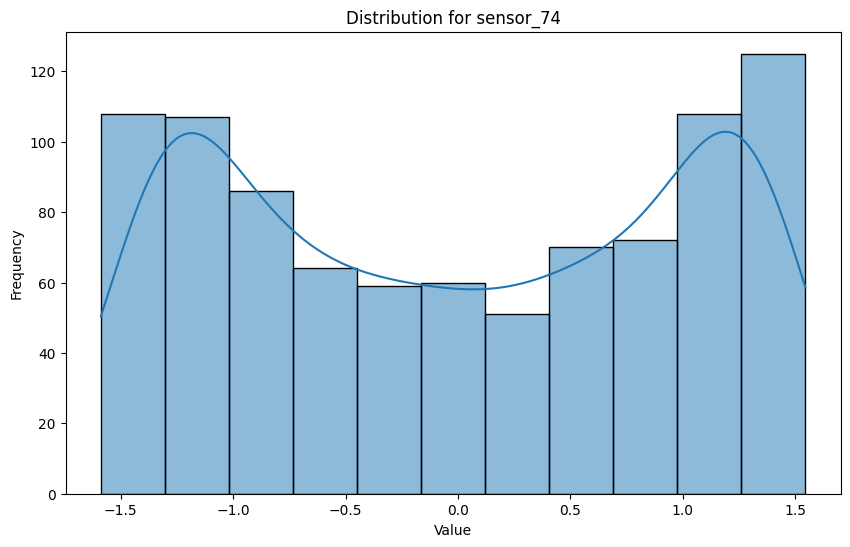

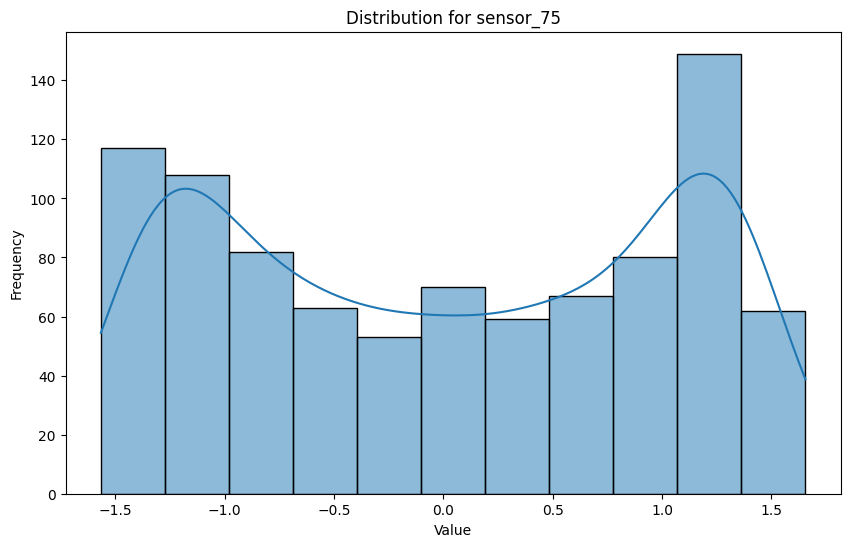

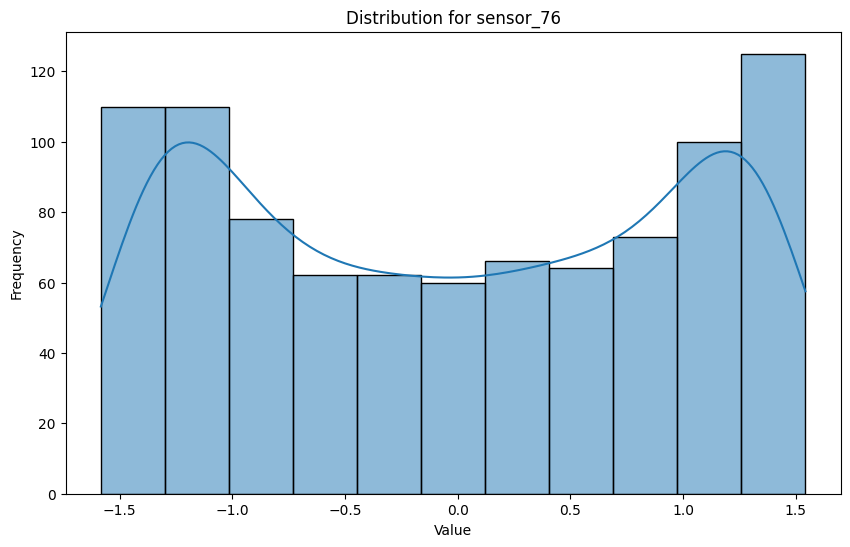

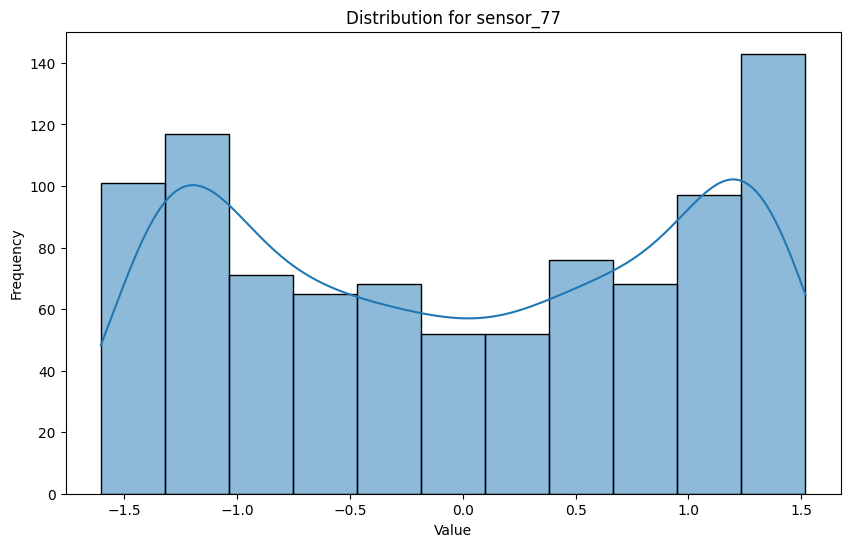

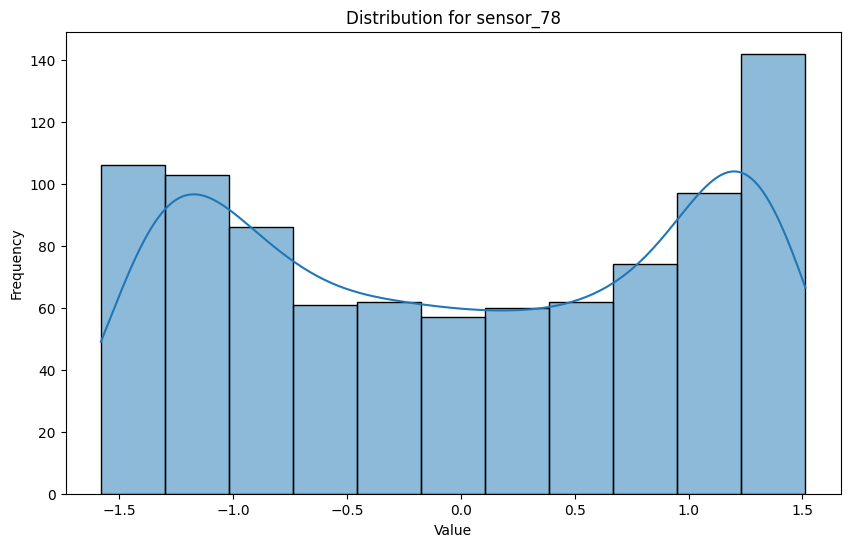

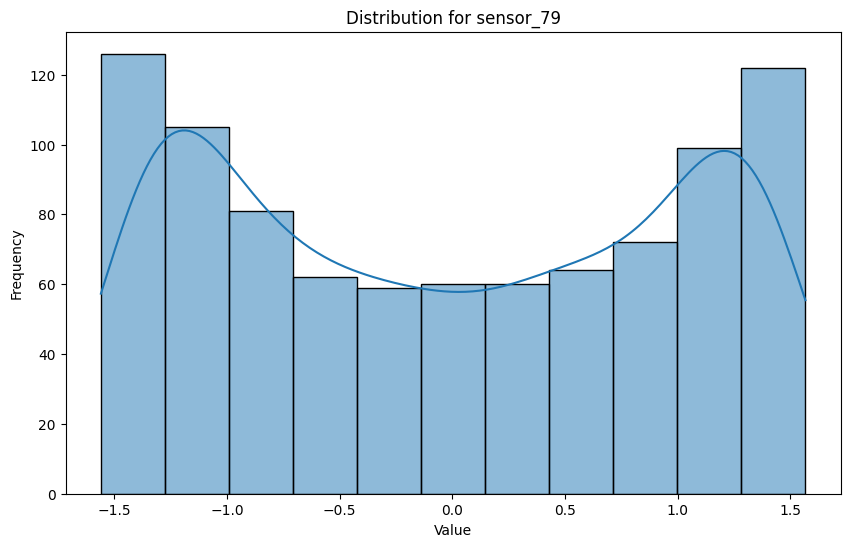

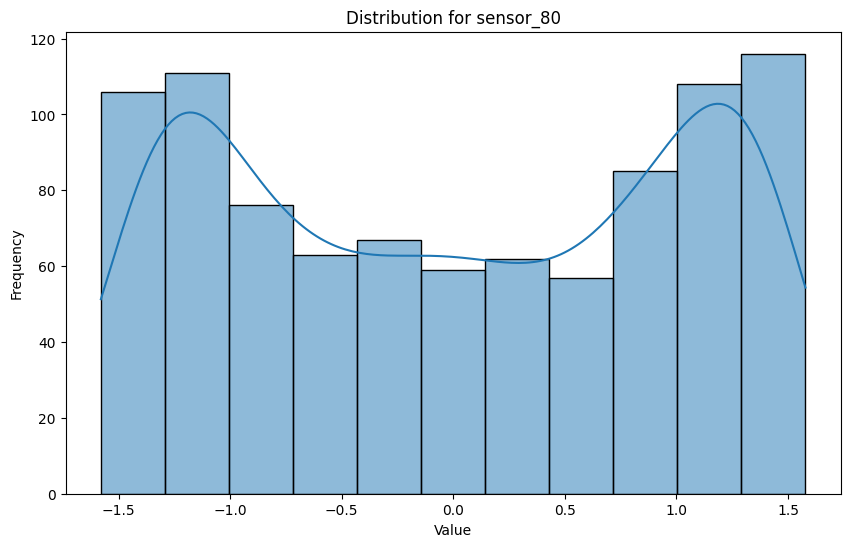

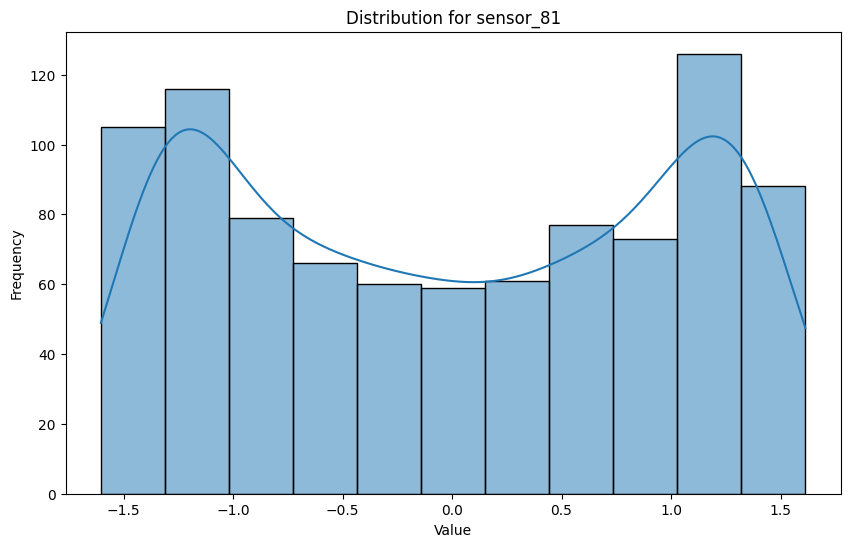

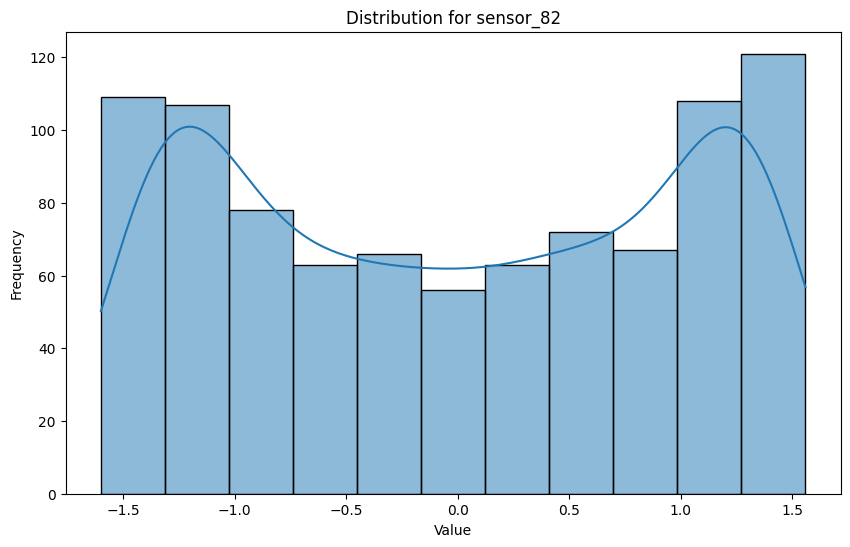

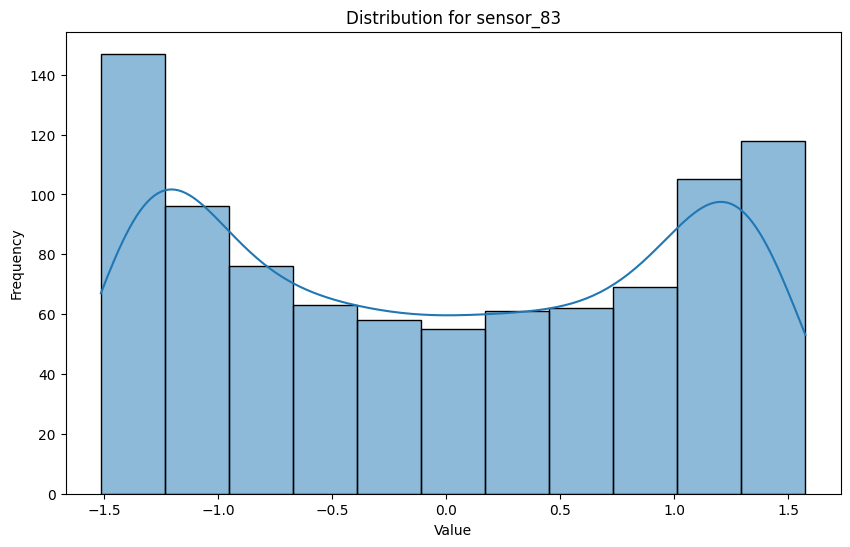

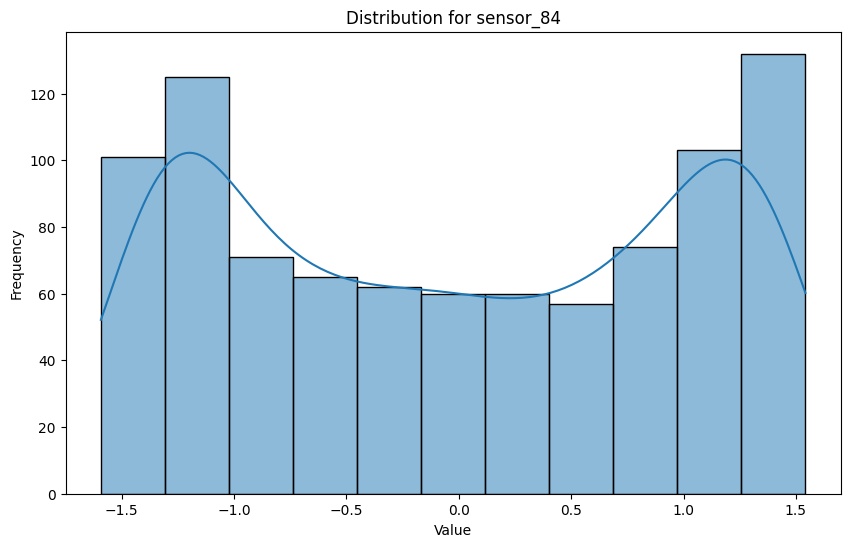

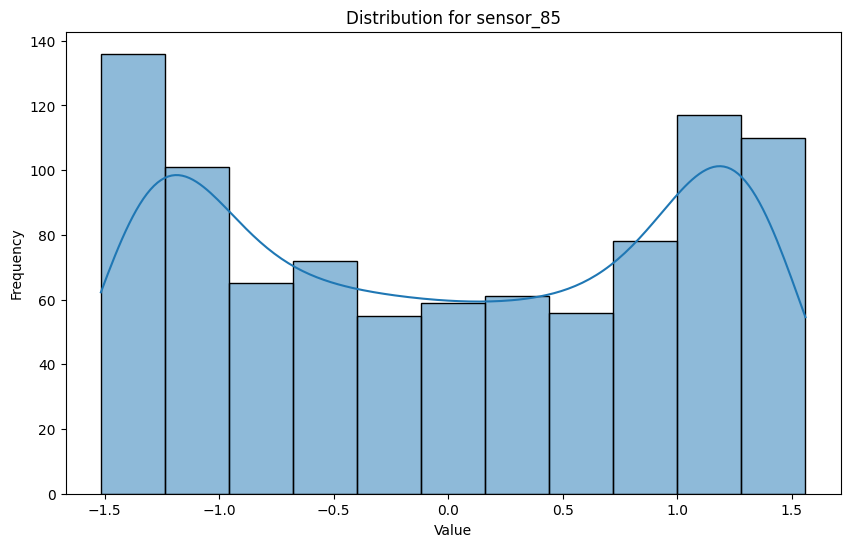

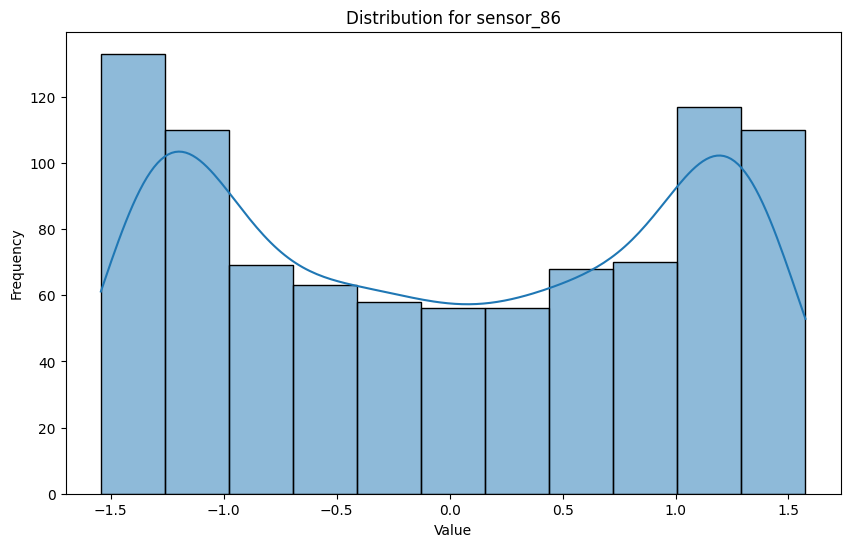

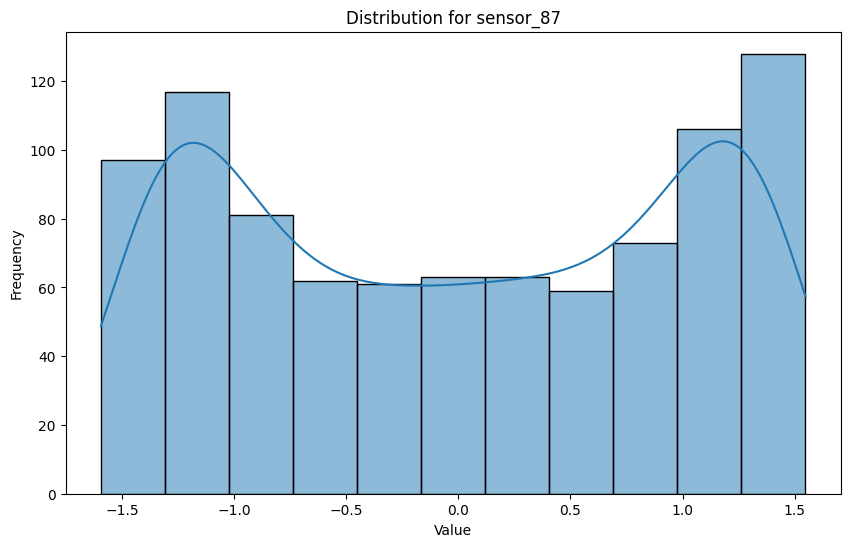

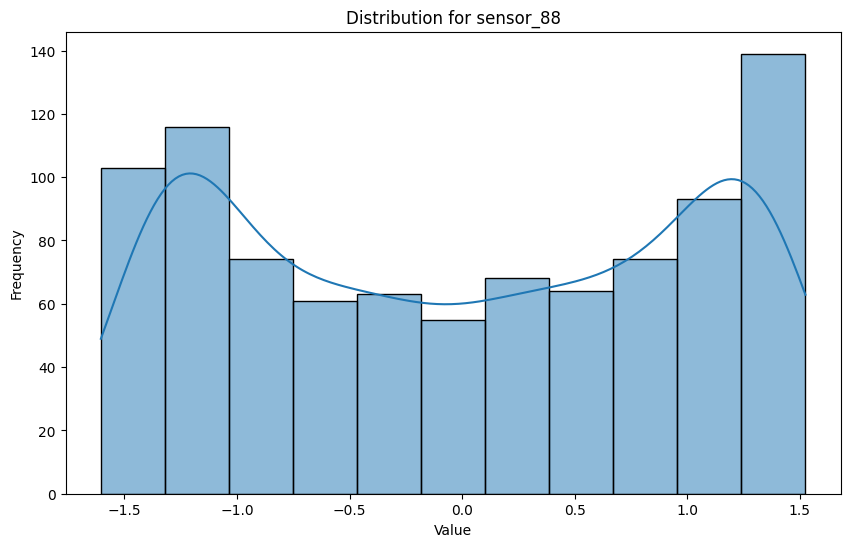

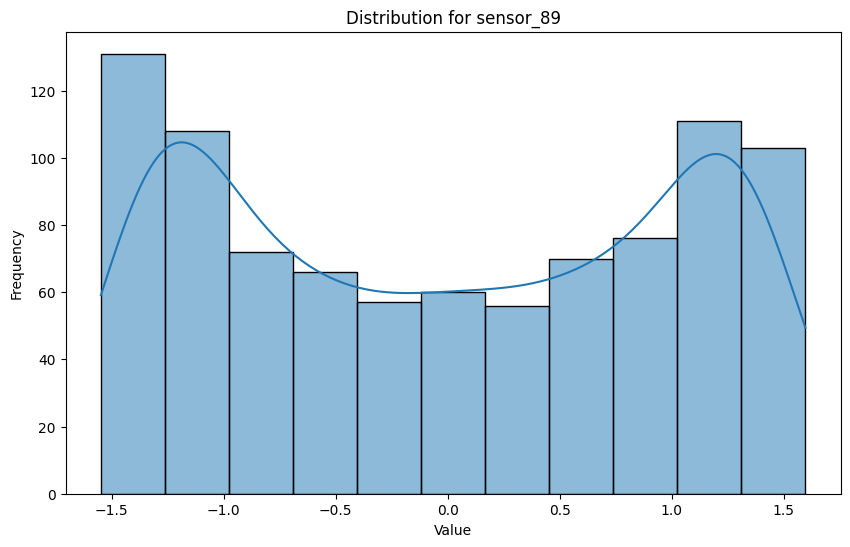

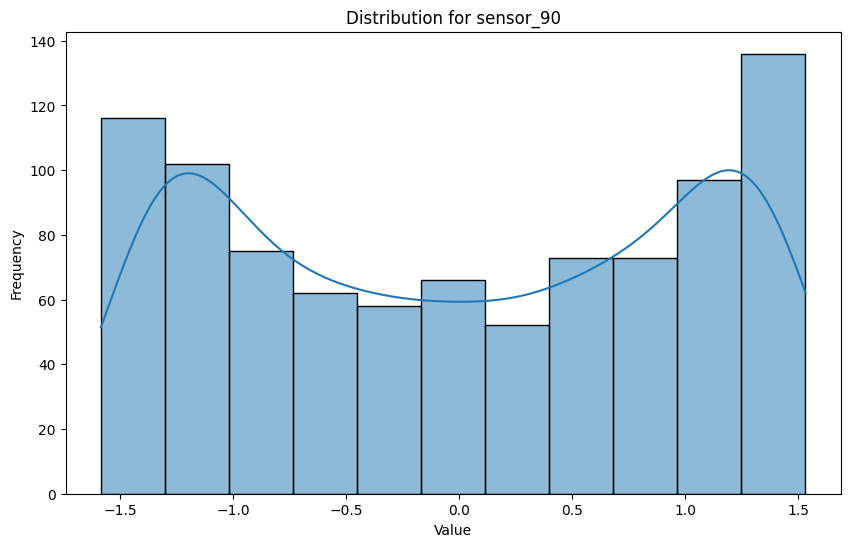

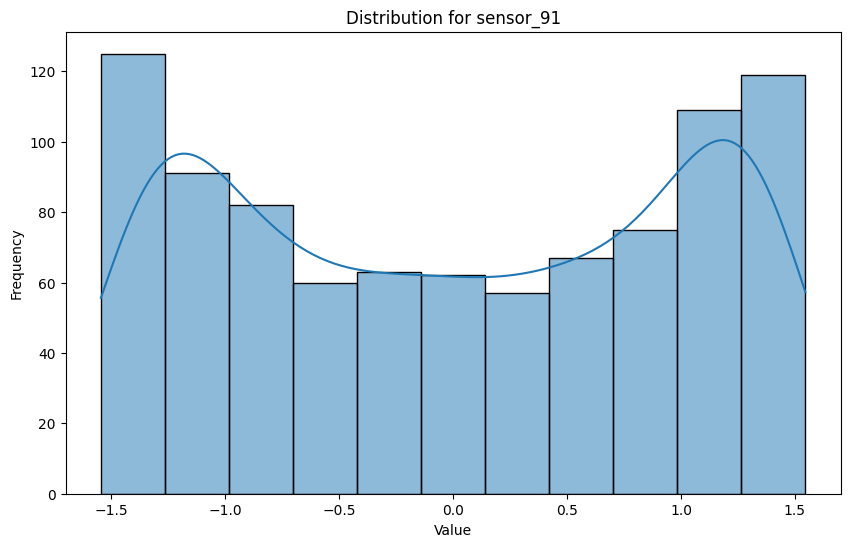

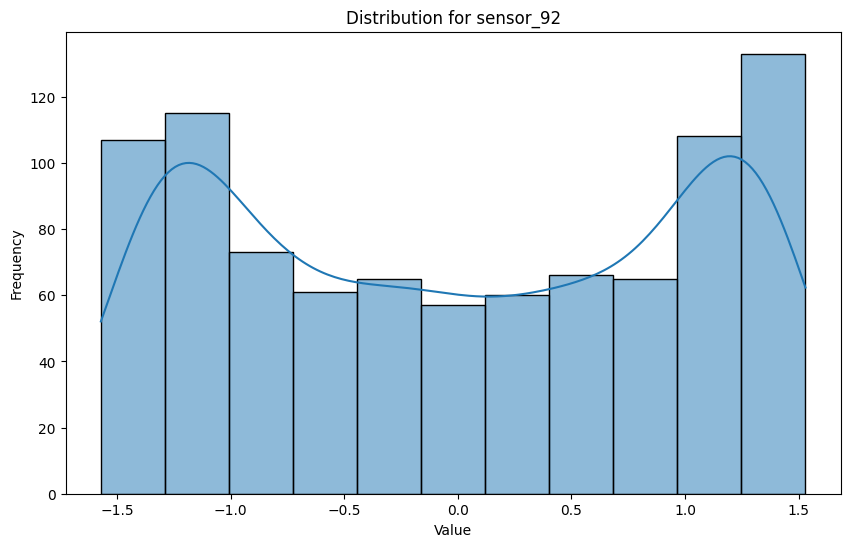

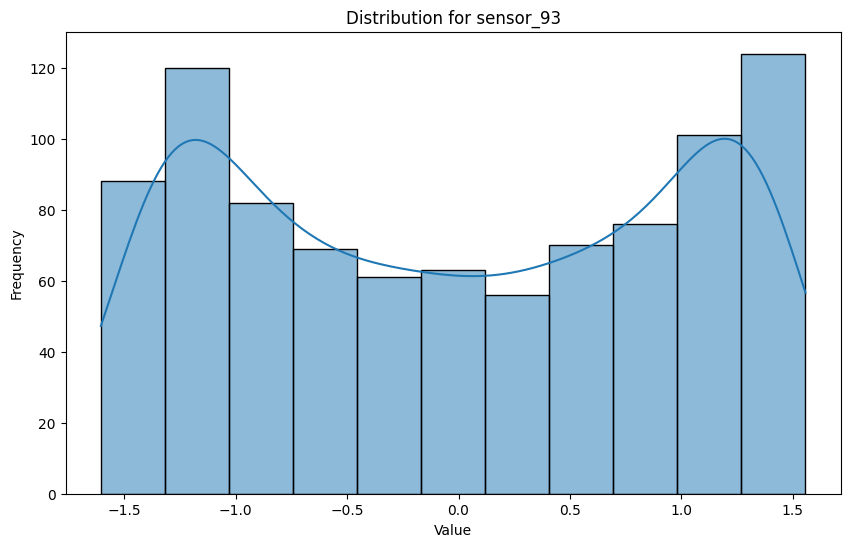

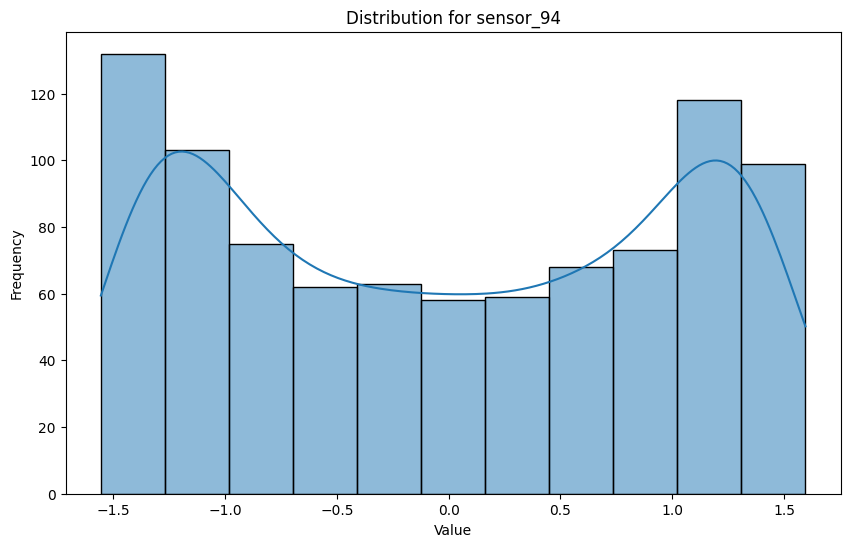

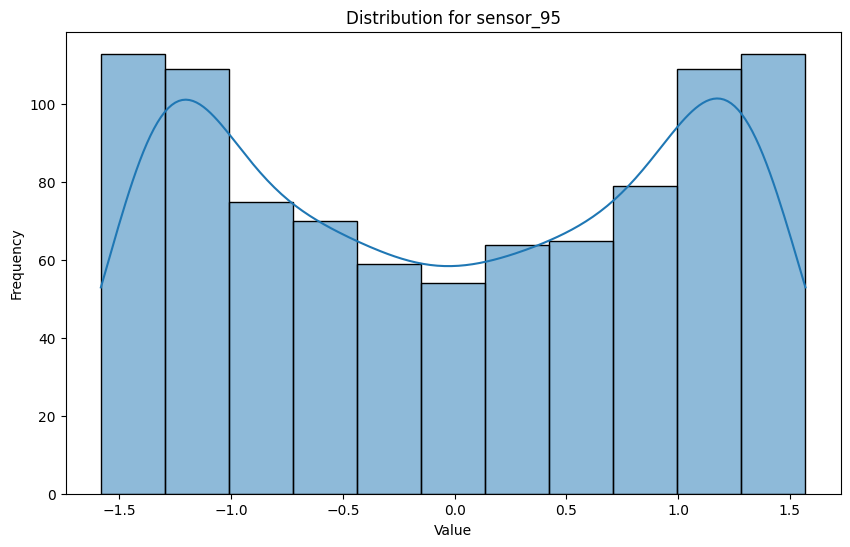

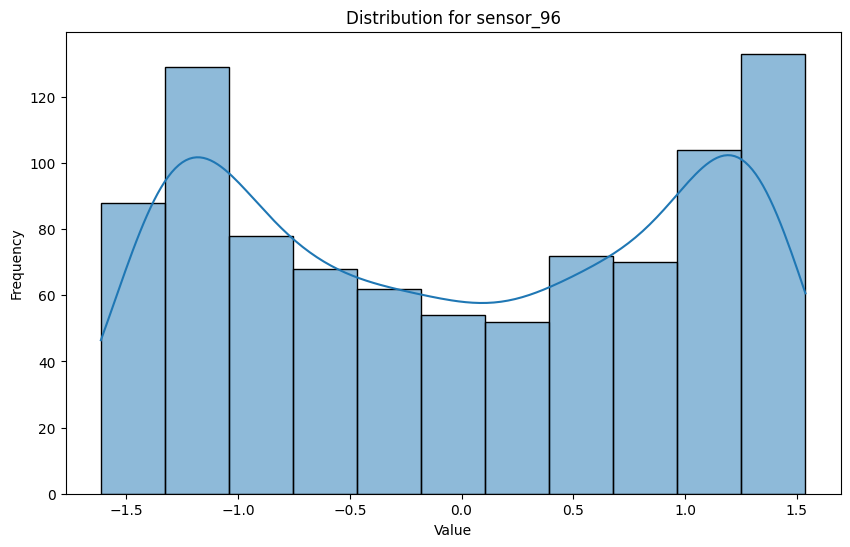

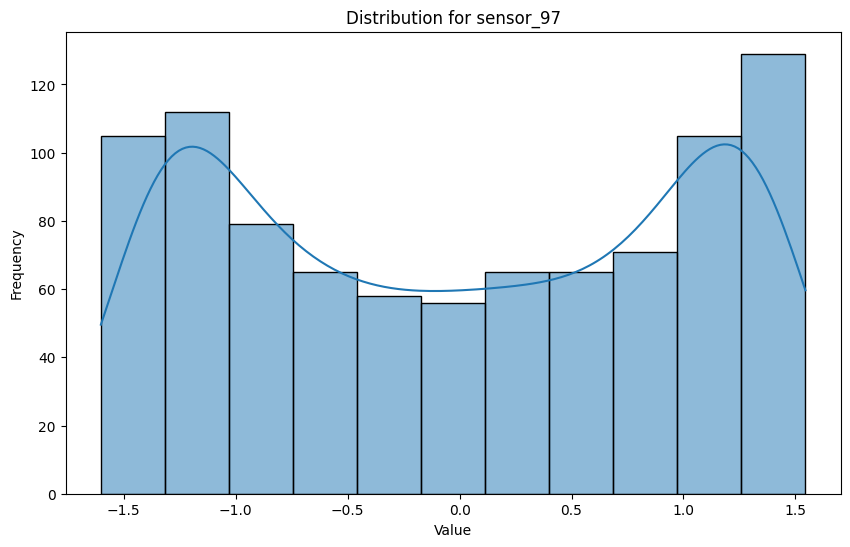

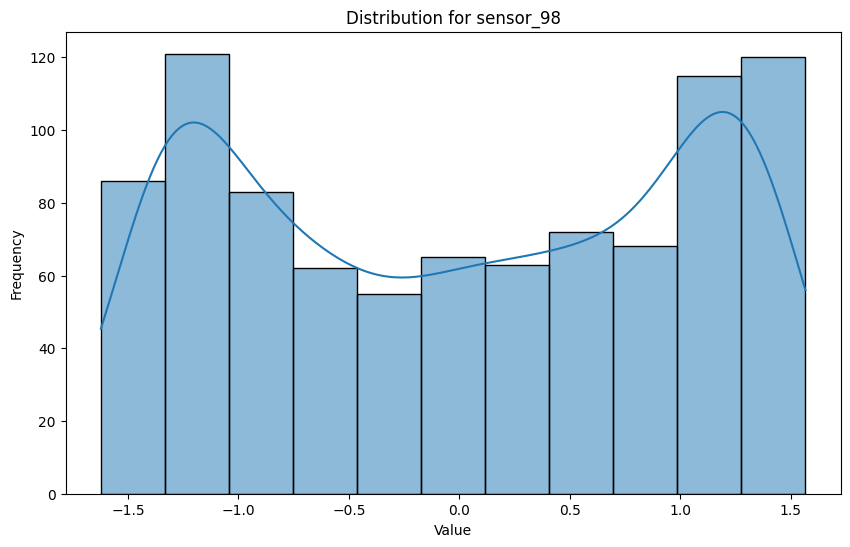

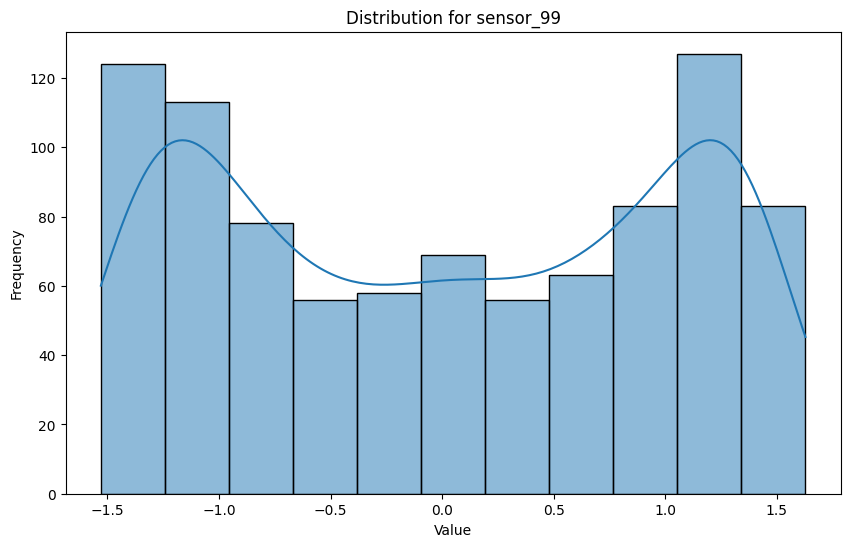

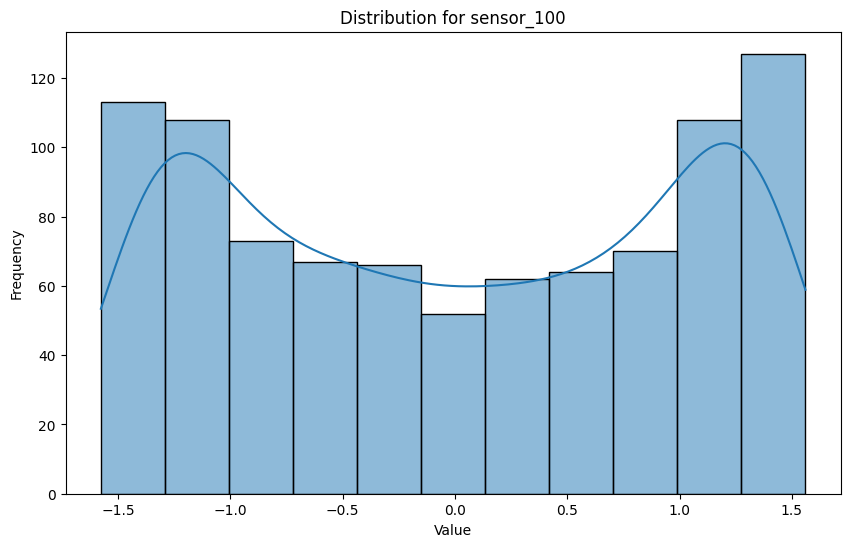

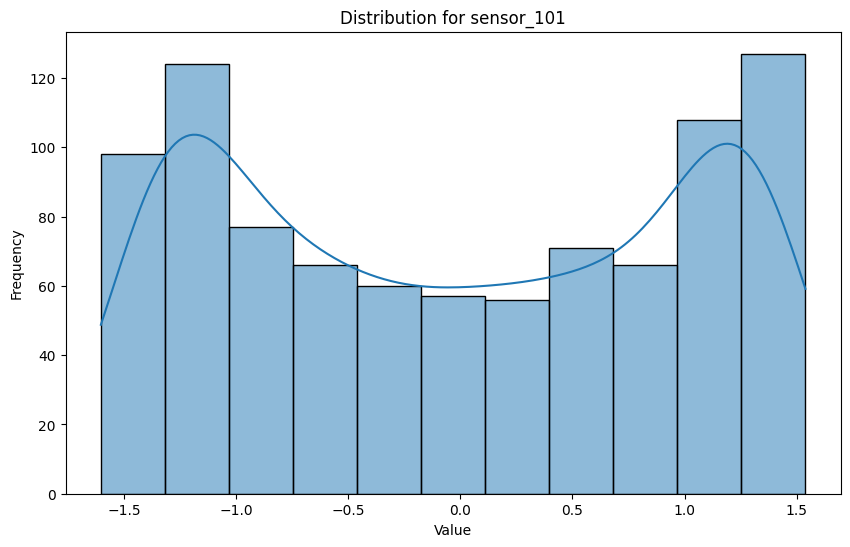

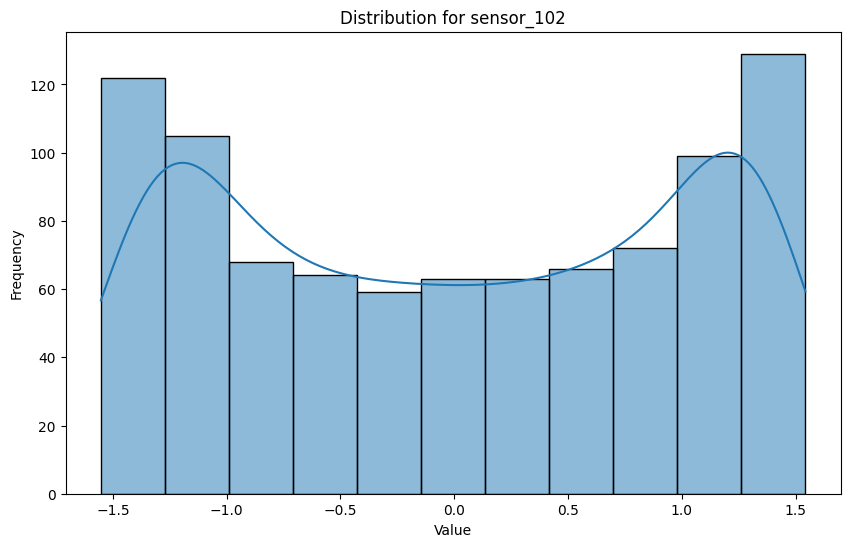

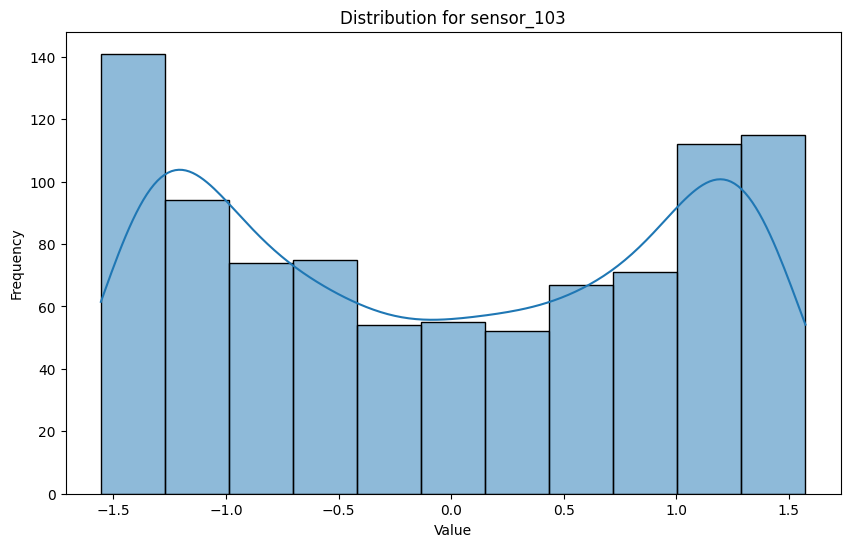

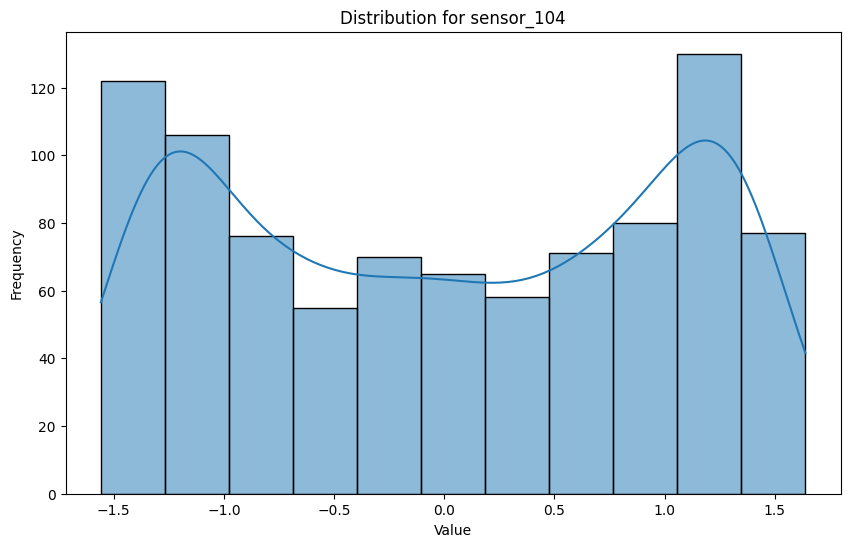

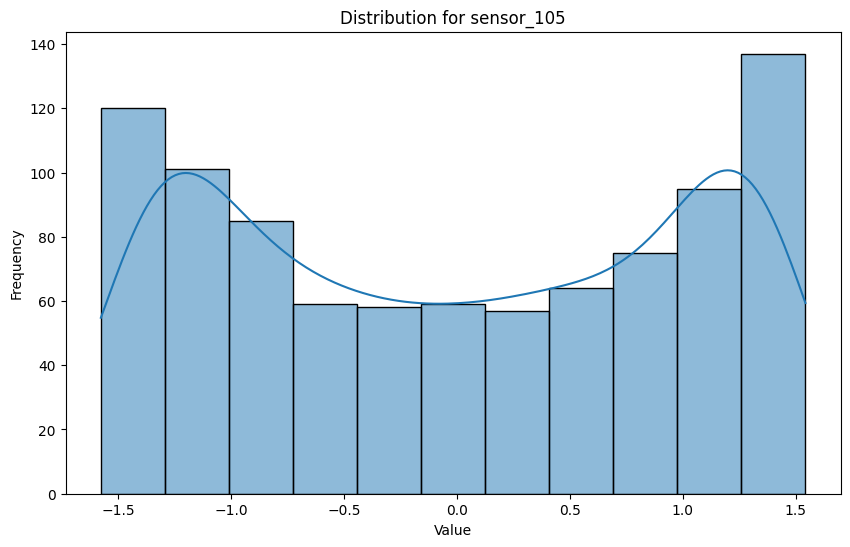

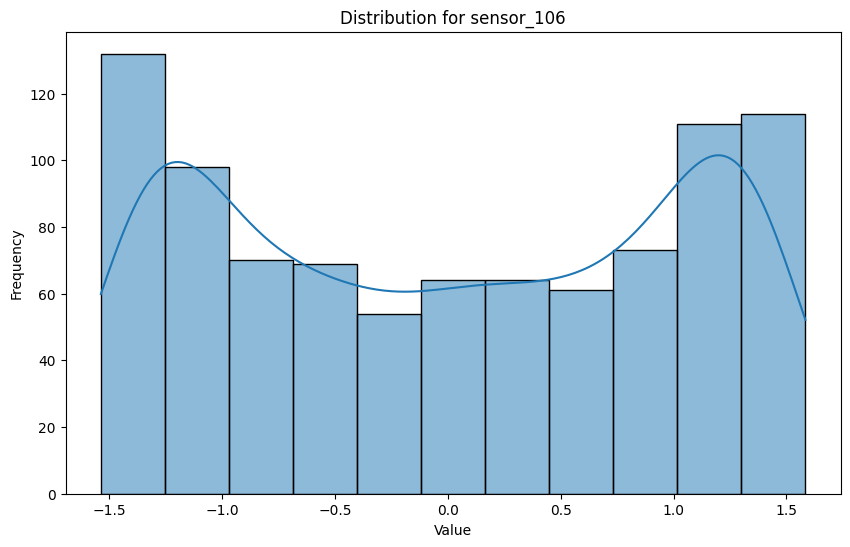

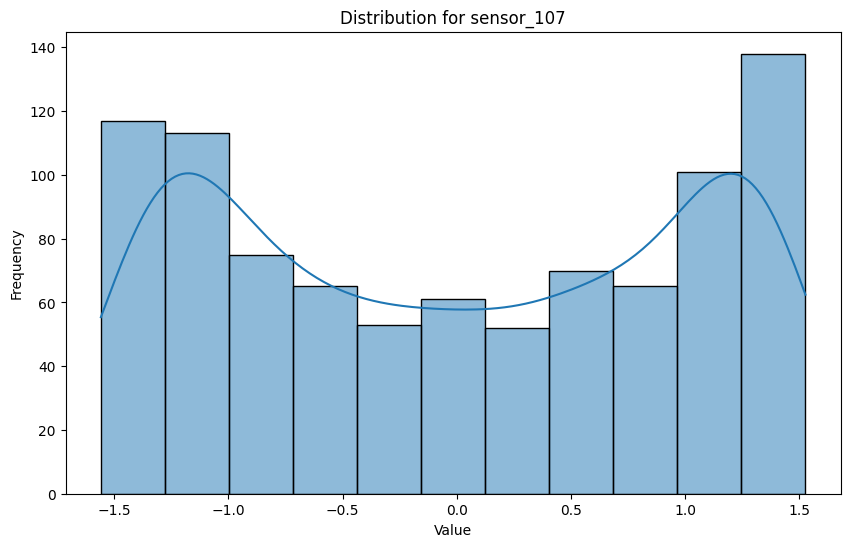

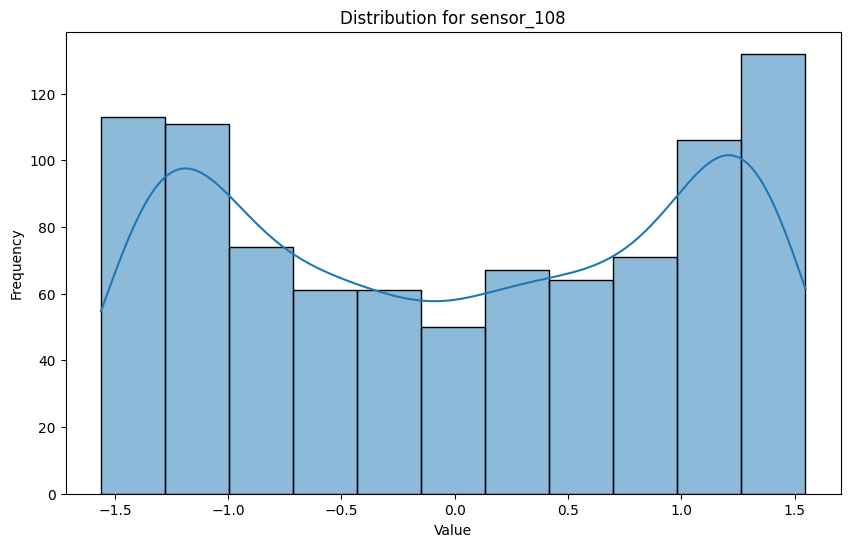

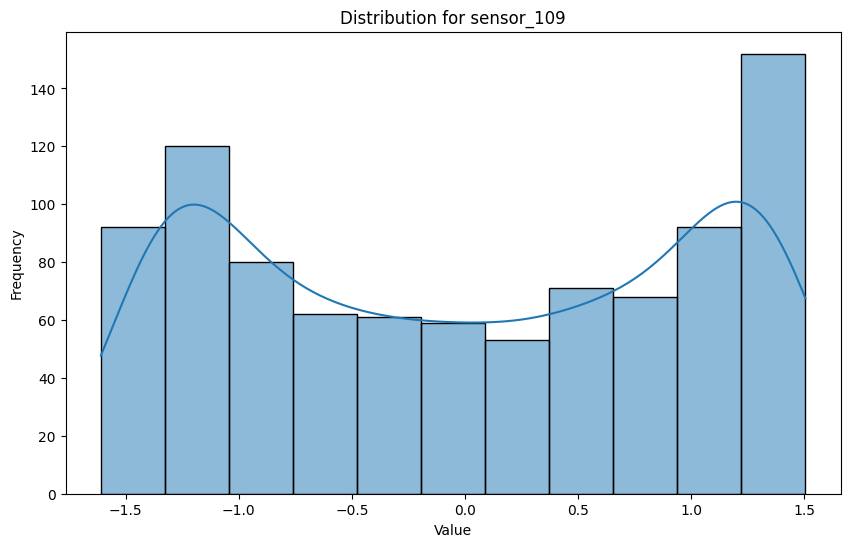

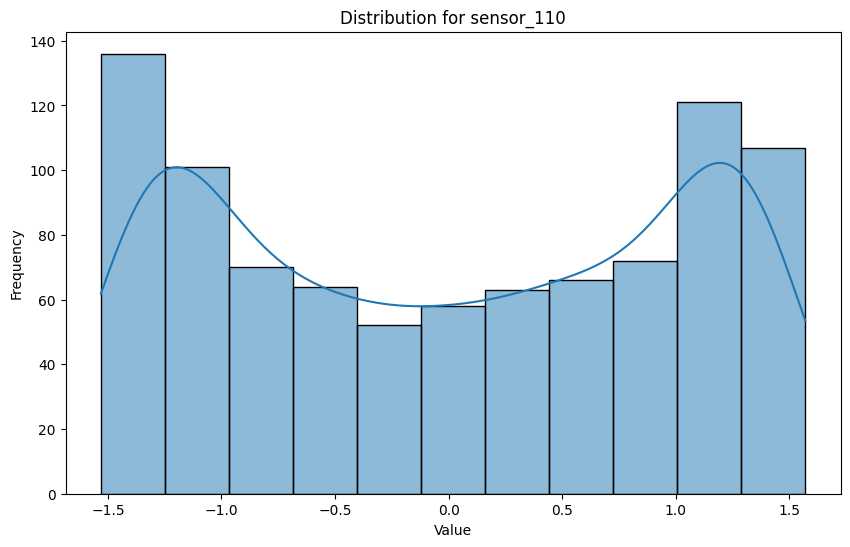

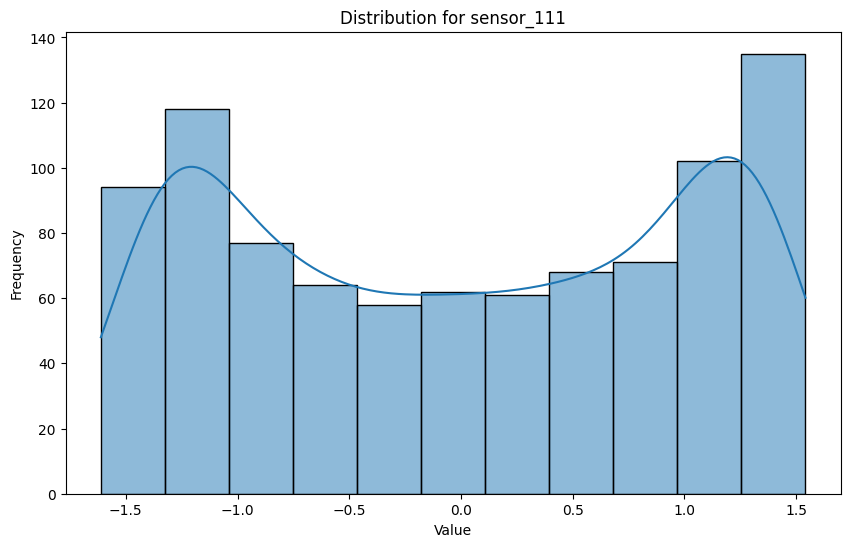

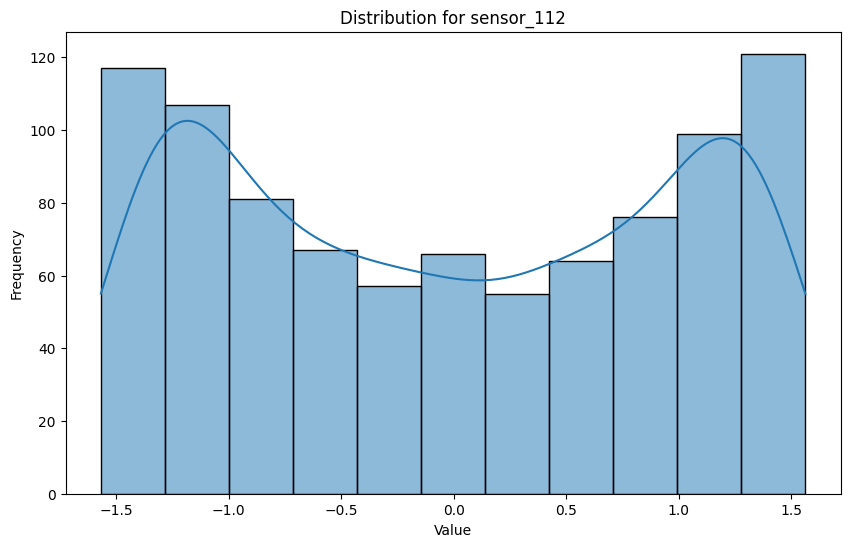

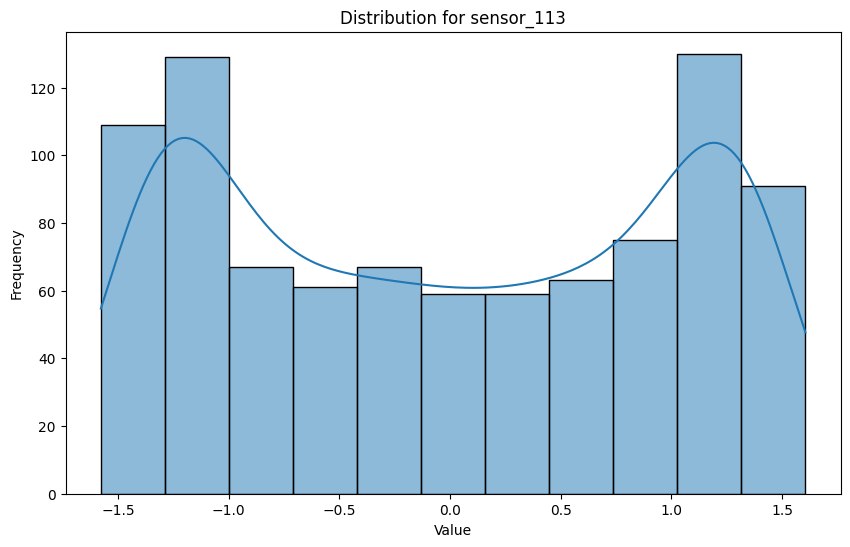

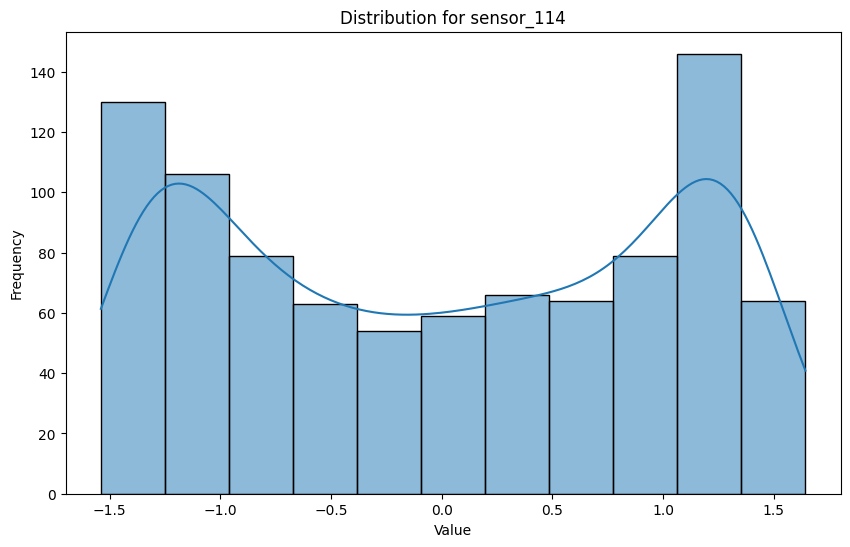

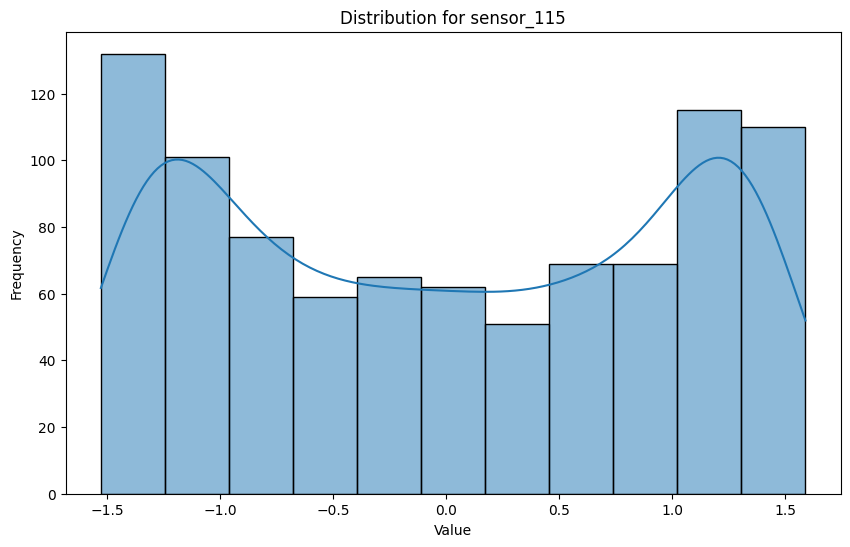

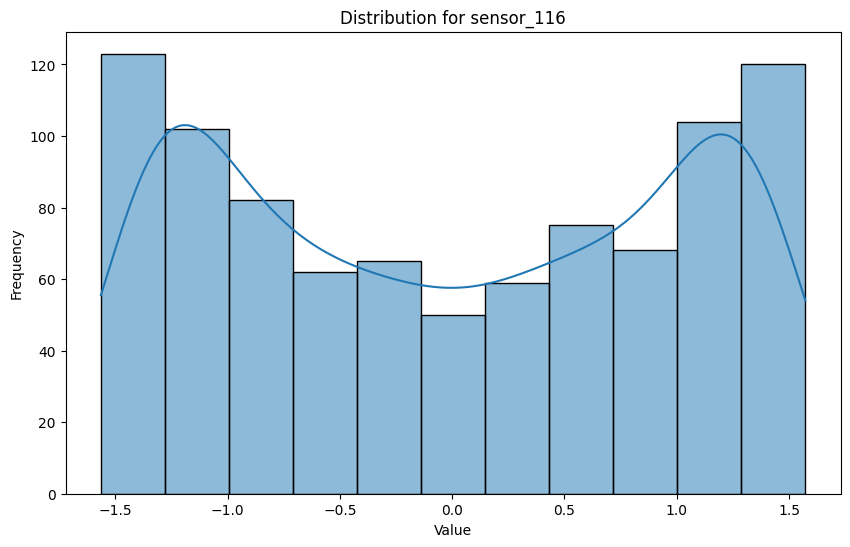

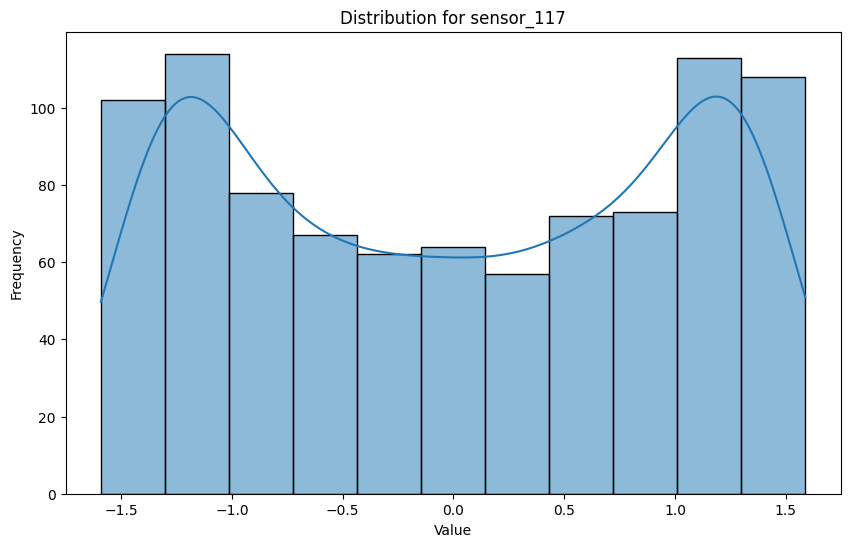

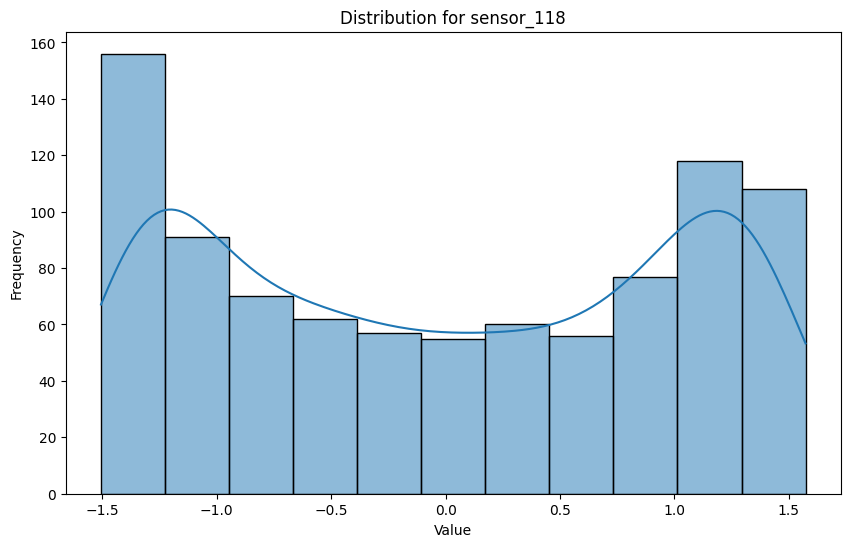

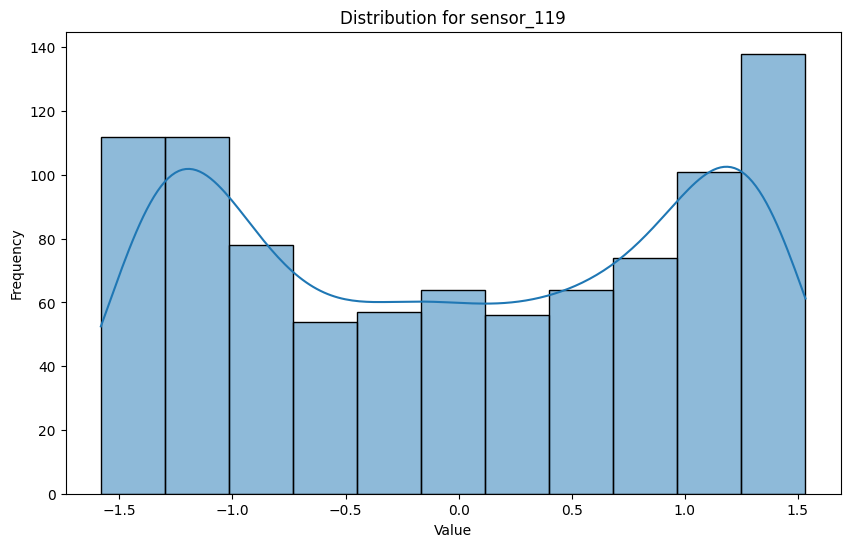

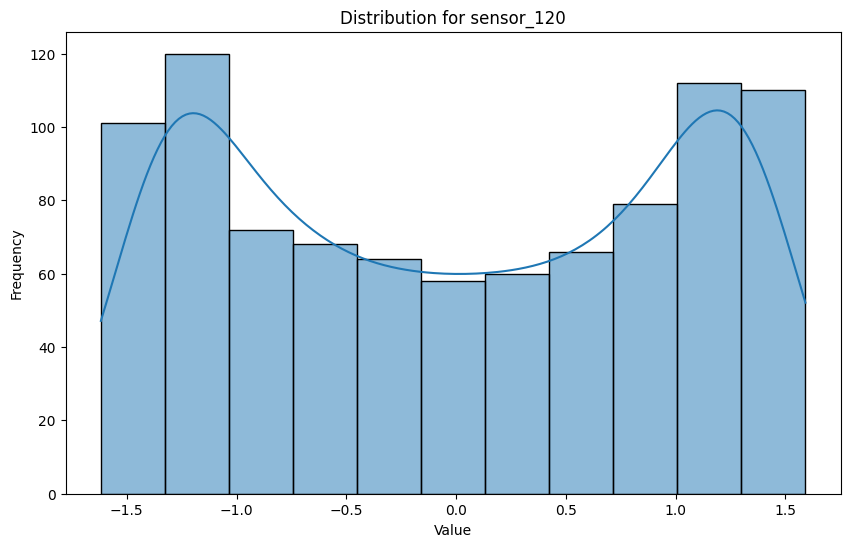

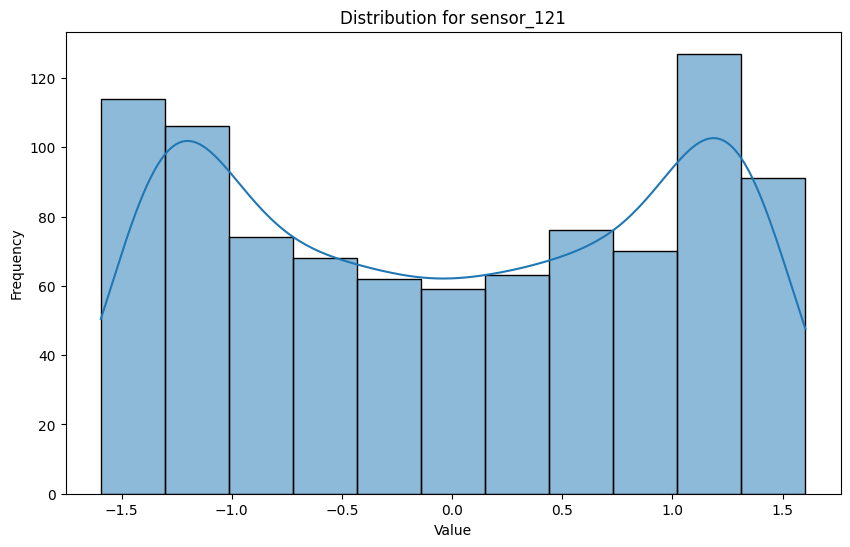

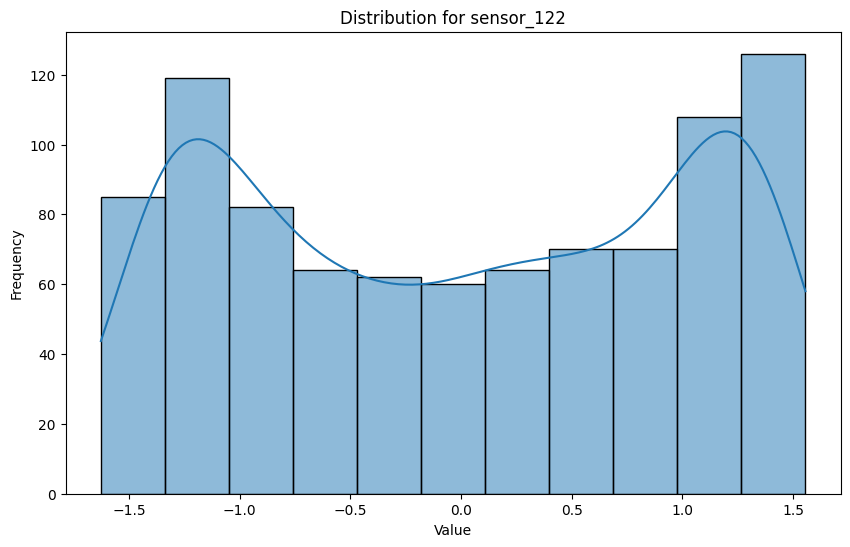

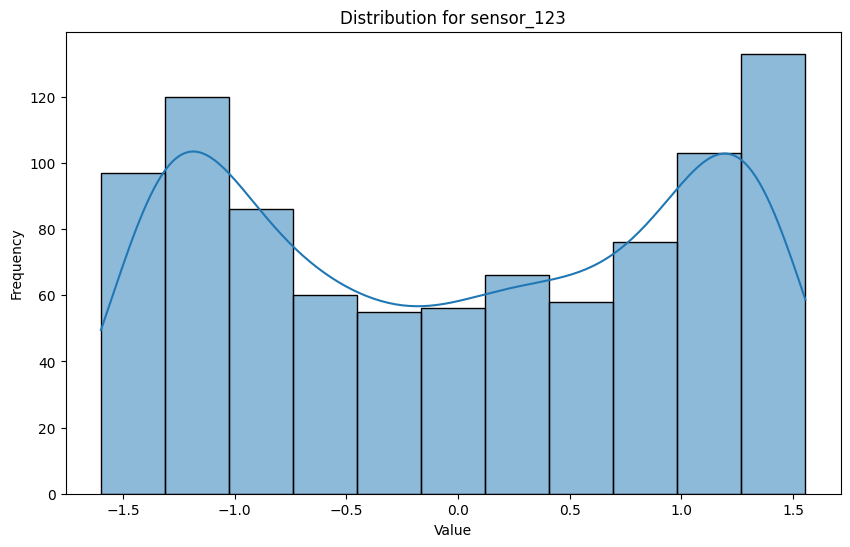

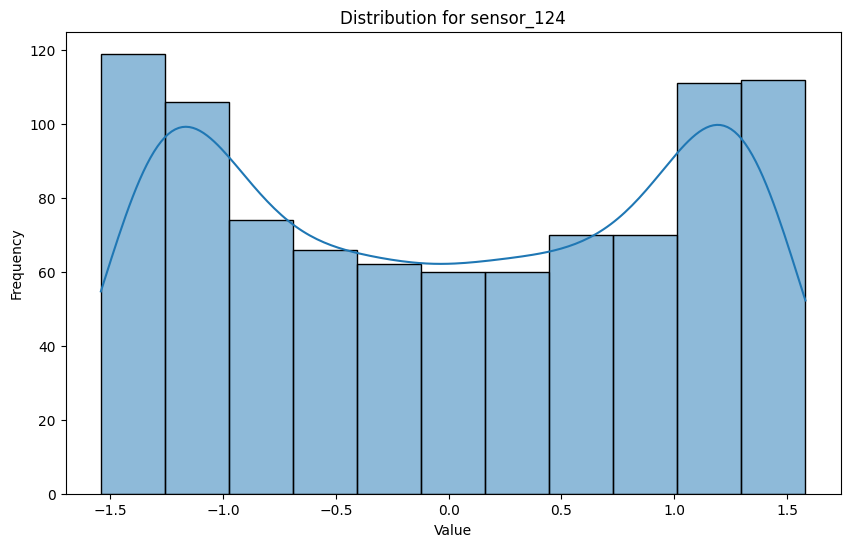

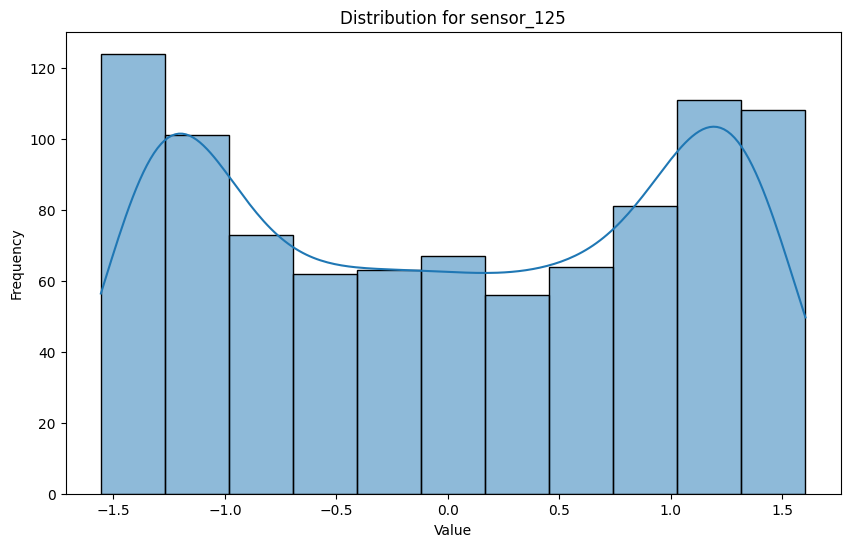

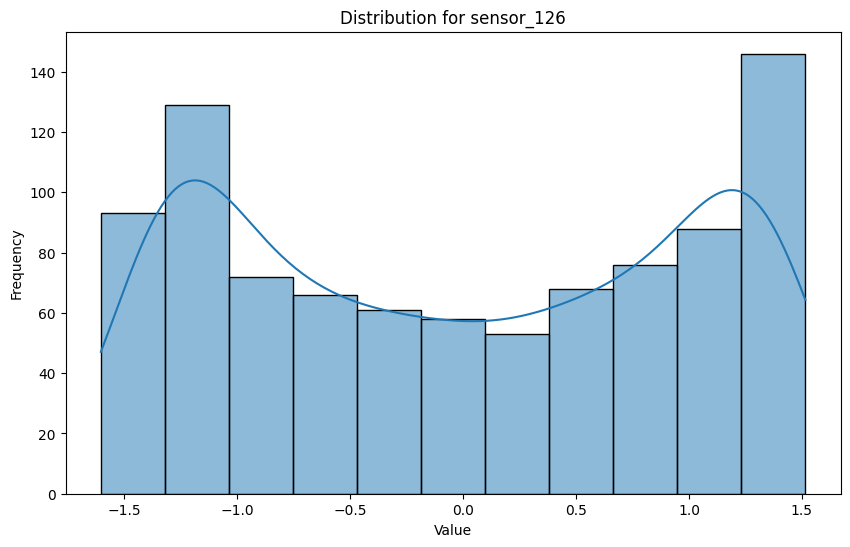

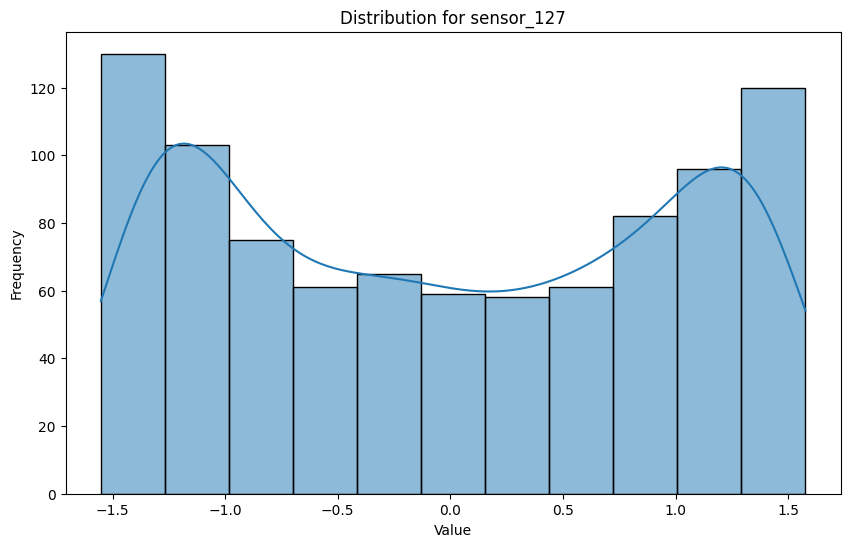

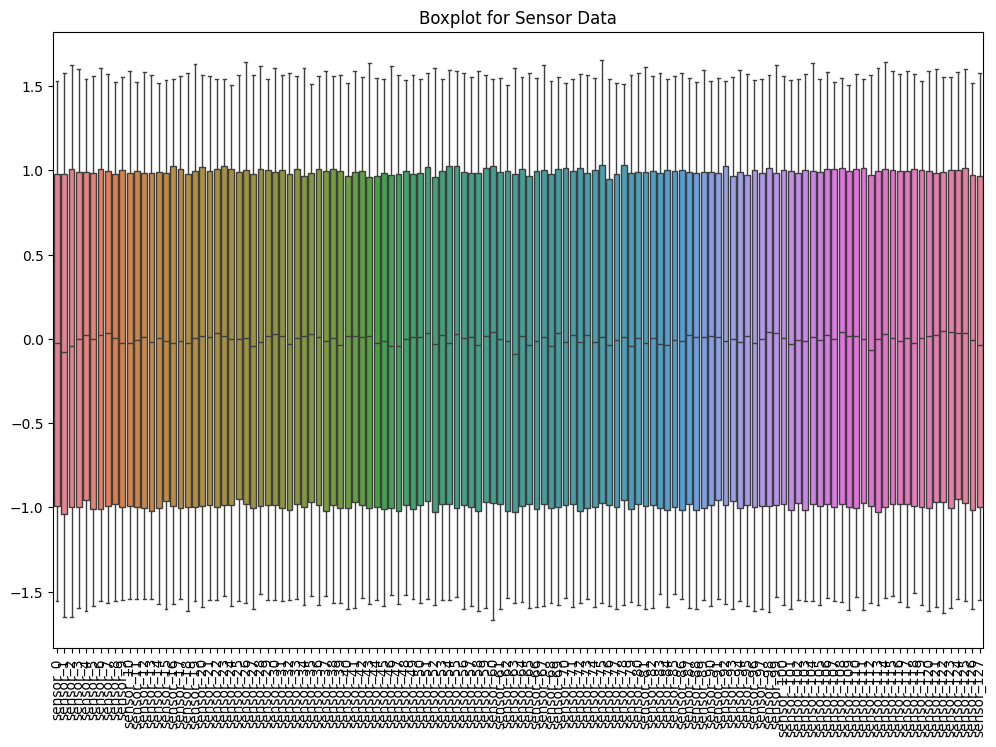

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Load the dataset
data = pd.read_csv('seph/synthetic_datasetV3.csv')  # Replace with your actual file path

# Visualization for Sensor Data
sensor_columns = [col for col in data.columns if 'sensor' in col]  # Adjust if necessary
sensor_data = data[sensor_columns]

# Histograms for each sensor
for sensor in sensor_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(sensor_data[sensor], kde=True)
    plt.title(f'Distribution for {sensor}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

# Boxplot for sensor data
plt.figure(figsize=(12, 8))
sns.boxplot(data=sensor_data)
plt.title('Boxplot for Sensor Data')
plt.xticks(rotation=90)
plt.show()

# Correlation Heatmap for sensor data
plt.figure(figsize=(12, 10))
sns.heatmap(sensor_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap for Sensor Data')
plt.show()

# Visualization for NLP Data
# Replace 'text_column' with your actual text column name
text_column = 'text'  # Adjust if necessary
text_data = data[text_column].dropna()  # Drop NaN if any

# Word Cloud for text data
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text_data))
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Text Data')
plt.show()